# LOAD Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
from scipy.stats import skew
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns
from scipy.stats import linregress

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges,sizes
from funciones.modelcube import modelmag,modelmagf,modelmag2

from IPython.display import display, HTML
display(HTML("<style>.output_scroll {height: 400px; overflow-y: scroll;}</style>"))

/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [3]:
DF=pd.read_csv('compare-params-TM3-B.csv')

In [4]:
DF[DF.AR == 8913]=DF[DF.AR == 8913].assign(fint=DF[DF.AR == 8913].flux/np.max(DF[DF.AR == 8913].flux))

In [5]:
DFt=DF.groupby(['AR']).min().reset_index()
len(DFt[(DFt.fint>=0.2) ].AR)

40

In [6]:
DF.groupby(['AR']).min().reset_index().fint

0      0.185196
1      0.022993
2      0.036494
3      0.042565
4      0.148544
         ...   
121    0.495468
122    0.041713
123    0.021182
124    0.067503
125    0.220401
Name: fint, Length: 126, dtype: float64

In [7]:
DF['alpha']=DF.apply(lambda x: -1*180*np.sign(x.lat)*x.alpha/np.pi,axis=1)
DF['alphab']=DF.apply(lambda x: -1*np.sign(x.lat)*x.alphab,axis=1)

In [8]:
DF=DF.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DF=DF.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

In [9]:
lidf=[]

lims=[0,0.25,0.5,0.75,1]

for i in range(4):
    DF2=DF[(DF.fint > lims[i]) & (DF.fint <= lims[i+1])].groupby(['AR']).mean().reset_index()
    DF2=DF2.assign(frange=i+1)

    lidf.append(DF2)

DF2=pd.concat(lidf)




# Tilt

In [42]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)


for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    
    sns.histplot(data=DFx,x='alpha',alpha=0.5,bins=10,binrange=(-60,60),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='alphab',alpha=0.5,bins=10,binrange=(-60,60),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.alpha.median(),color='tab:blue')
    axs[d-1].axvline(DFx.alphab.median(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                     \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['alpha','alphab']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"α > 0:\nα < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.18, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.24, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.7, 0.58, f"                  \n               ",
         transform=axs[d-1].transAxes,
         fontsize=14,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.7, 0.65, r"$\alpha_{med}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.81, 0.65, f"{DFx.alpha.median():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.89, 0.65, f"{DFx.alphab.median():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    axs[d-1].text(0.7, 0.59, r"$\sigma_\alpha:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.81, 0.59, f"{DFx.alpha.std():.0f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.89, 0.59, f"{DFx.alphab.std():.0f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('ARs',fontsize=14)
axs[2].set_ylabel('ARs',fontsize=14)

axs[2].set_xlabel(r'$\alpha$ [deg]',fontsize=14)
axs[3].set_xlabel(r'$\alpha$ [deg]',fontsize=14)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)



fig.tight_layout(pad=1.0)

plt.savefig('./plotilt/alphas.pdf',dpi=300)

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12),sharex=True)



for en,ra in enumerate([(0,12),(12,20),(20,45)]):
    axs[en].set_ylim(-50,50)

    axs[en].axhline(0,color='black')

    sns.scatterplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='alpha',alpha=0.5,s=30)
    sns.scatterplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='alphab',alpha=0.5,s=30)

    sns.regplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='alpha',color='tab:red',x_bins=10,label='Bayesian')
    sns.regplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='alphab',color='tab:green',x_bins=10,label='Barycenters')
    axs[en].legend()
    
    axs[en].text(.7,.1,rf'${ra[0]}^\circ<|lat|\leq {ra[1]}^\circ$', transform=axs[en].transAxes, fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round',alpha=0.5))
#    plt.set_xlabel('Normalized flux')
    axs[en].set_ylabel(r'$\alpha$ [deg]')
    
fig.tight_layout(pad=1.0)

axs[2].set_xlabel('Normalized flux')



In [44]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)

DF2x=DF2[(DF2.lat.abs() >=12) & (DF2.lat.abs() <20)]


for d in [1,2,3,4]:

    
    DFx=DF2x[(DF2x['frange']==d)]
    
    sns.histplot(data=DFx,x='alpha',alpha=0.5,bins=10,binrange=(-60,60),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='alphab',alpha=0.5,bins=10,binrange=(-60,60),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.alpha.median(),color='tab:blue')
    axs[d-1].axvline(DFx.alphab.median(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                     \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['alpha','alphab']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"α > 0:\nα < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.18, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.24, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.75, 0.65, f"                ",
         transform=axs[d-1].transAxes,
         fontsize=12,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.75, 0.65, r"$\bar{\alpha}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.8, 0.65, f"{DFx.alpha.median():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.87, 0.65, f"{DFx.alphab.median():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)
    
       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('Active regions')
axs[2].set_ylabel('Active regions')

axs[2].set_xlabel(r'$\alpha$ [deg]')
axs[3].set_xlabel(r'$\alpha$ [deg]')


fig.tight_layout(pad=1.0)

fig.show()

# Rot

In [45]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)


for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    
    sns.histplot(data=DFx,x='rot',alpha=0.5,bins=10,binrange=(-2,2),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='rotb',alpha=0.5,bins=10,binrange=(-2,2),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.rot.median(),color='tab:blue')
    axs[d-1].axvline(DFx.rotb.median(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                     \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['rot','rotb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"Δα > 0:\nΔα < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.2, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.26, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.7, 0.58, f"                    \n               ",
         transform=axs[d-1].transAxes,
         fontsize=14,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.7, 0.65, r"$\Delta\alpha_{med}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.65, f"{DFx.rot.median():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.65, f"{DFx.rotb.median():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    axs[d-1].text(0.7, 0.59, r"$\sigma_{\Delta\alpha}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.59, f"{DFx.rot.std():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.59, f"{DFx.rotb.std():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)
    
       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('Active regions',fontsize=14)
axs[2].set_ylabel('Active regions',fontsize=14)

axs[2].set_xlabel(r'$\Delta \alpha$ [deg/hour]',fontsize=14)
axs[3].set_xlabel(r'$\Delta \alpha$ [deg/hour]',fontsize=14)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)


fig.tight_layout(pad=1.0)

plt.savefig('./plotilt/rotalpha.pdf',dpi=300)

In [46]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)


for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    DFx=DFx.assign(ratea=lambda x: x.alpha*x.rot)
    DFx=DFx.assign(rateb=lambda x: x.alphab*x.rotb)
    
    DFx=DFx[(DFx.ratea.abs()<=10) & (DFx.rateb.abs()<=10)]
    
    sns.histplot(data=DFx,x='ratea',alpha=0.5,bins=10,binrange=(-8,8),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='rateb',alpha=0.5,bins=10,binrange=(-8,8),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.ratea.mean(),color='tab:blue')
    axs[d-1].axvline(DFx.rateb.mean(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                     \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['ratea','rateb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"αΔα > 0:\nαΔα < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.2, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.26, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.7, 0.58, f"                    \n               ",
         transform=axs[d-1].transAxes,
         fontsize=14,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.7, 0.65, r"$\Delta\alpha_{med}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.65, f"{DFx.ratea.median():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.65, f"{DFx.rateb.median():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    axs[d-1].text(0.7, 0.59, r"$\sigma_{\Delta\alpha}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.59, f"{DFx.ratea.std():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.59, f"{DFx.rateb.std():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)
    
       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('ARs',fontsize=14)
axs[2].set_ylabel('ARs',fontsize=14)

axs[2].set_xlabel(r'$\alpha\Delta \alpha$ [deg**2/hour]',fontsize=14)
axs[3].set_xlabel(r'$\alpha\Delta \alpha$ [deg**2/hour]',fontsize=14)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)
    
fig.tight_layout(pad=1.0)

In [47]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)


for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    DFx=DFx.assign(ratea=lambda x: x.rot/x.alpha)
    DFx=DFx.assign(rateb=lambda x: x.rotb/x.alphab)
    
    DFx=DFx[(DFx.ratea.abs()<=1) & (DFx.rateb.abs()<=1)]
    
    sns.histplot(data=DFx,x='ratea',alpha=0.5,bins=20,binrange=(-0.5,0.5),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='rateb',alpha=0.5,bins=20,binrange=(-0.5,0.5),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.ratea.median(),color='tab:blue')
    axs[d-1].axvline(DFx.rateb.median(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                           \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['ratea','rateb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"Δα/α > 0:\nΔα/α < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.24, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.3, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.7, 0.58, f"                    \n               ",
         transform=axs[d-1].transAxes,
         fontsize=14,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.7, 0.65, r"$\Delta\alpha_{med}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.65, f"{DFx.ratea.median():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.65, f"{DFx.rateb.median():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    axs[d-1].text(0.7, 0.59, r"$\sigma_{\Delta\alpha}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.83, 0.59, f"{DFx.ratea.std():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.91, 0.59, f"{DFx.rateb.std():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)
    
       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('Active regions',fontsize=14)
axs[2].set_ylabel('Active regions',fontsize=14)

axs[2].set_xlabel(r'$\Delta \alpha/\alpha$ [1/hour]',fontsize=14)
axs[3].set_xlabel(r'$\Delta \alpha/\alpha$ [1/hour]',fontsize=14)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout(pad=1.0)

plt.savefig('./plotilt/fracalpha.pdf',dpi=300)

# Check multimodal

In [48]:
ars=list(set(DF.AR.values))
len(ars)

In [49]:
from diptest import diptest

multiars=[]

#for name in list(set(DF.AR.values)):
for name in ars:
    

    try:
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    except:
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')

    for i in list(set(DF1['mag'].values)):
        data=DF1[DF1['mag']==i]['alpha'].values
        # Aplicar prueba de dip
        dip_stat, p_value = diptest(data)
      #  print(f"Estadístico de dip: {dip_stat}, p-valor: {p_value}")
        if p_value < 0.05:
            print(str(name)+'----------------------------------')
            multiars.append(name)
            print("La distribución es multimodal (rechazo de unimodalidad).")
            sns.kdeplot(data)
        else:
            pass
#            print("La distribución no es significativamente multimodal.")
    plt.show()

In [ ]:
multiars
dic={}
for name in set(multiars):
    dic[name]=multiars.count(name)

In [ ]:
dic

In [ ]:
from diptest import diptest


DFc=[]
DFu=[]
DFl=[]
DFs=[]

#for name in list(set(DF.AR.values)):
for name in set(multiars):
    

    try:
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    except:
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
    #sns.kdeplot(data=DF1,x='alpha',color='black')
    for i in list(set(DF1['mag'].values)):
        data=DF1[DF1['mag']==i]['alpha'].values
        # Aplicar prueba de dip
        dip_stat, p_value = diptest(data)
      #  print(f"Estadístico de dip: {dip_stat}, p-valor: {p_value}")
        if p_value < 0.05:
            mmd=np.median(data)
            DFu.append(DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].assign(AR=name))
            DFl.append(DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].assign(AR=name))
            if DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].std().alpha < DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].std().alpha:
                DFs.append(DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].assign(AR=name))
            else:
                DFs.append(DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].assign(AR=name))
                
                
            print(str(name)+'----------------------------------')
            print("La distribución es multimodal (rechazo de unimodalidad).")
        #    sns.kdeplot(data)
        else:
            DFc.append(DF1[DF1['mag']==i].assign(AR=name))
            DFs.append(DF1[DF1['mag']==i].assign(AR=name))
            pass
        
#            print("La distribución no es significativamente multimodal.")
   # plt.show()
    
DFc=pd.concat(DFc)
DFu=pd.concat(DFu)
DFl=pd.concat(DFl)
DFs=pd.concat(DFs)


In [ ]:
from diptest import diptest
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde


DFc=[]
DFu=[]
DFl=[]
DFs=[]

#for name in list(set(DF.AR.values)):
for name in set(multiars):
    

    try:
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    except:
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
    #sns.kdeplot(data=DF1,x='alpha',color='black')
    for i in list(set(DF1['mag'].values)):
        data=DF1[DF1['mag']==i]['alpha'].values
        # Aplicar prueba de dip
        dip_stat, p_value = diptest(data)
      #  print(f"Estadístico de dip: {dip_stat}, p-valor: {p_value}")
        if p_value < 0.05:
            # Estimación de densidad usando KDE
            kde = gaussian_kde(data)
            x_vals = np.linspace(min(data) - 1, max(data) + 1, 1000)
            density = kde(x_vals)

            # Detectamos los máximos locales
            peaks, _ = find_peaks(density)
                        
            mmd=np.mean(x_vals[peaks])
            DFu.append(DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].assign(AR=name))
            DFl.append(DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].assign(AR=name))
            if DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].std().alpha < DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].std().alpha:
                DFs.append(DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].assign(AR=name))
            else:
                DFs.append(DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].assign(AR=name))
                
                
            print(str(name)+'----------------------------------')
            print("La distribución es multimodal (rechazo de unimodalidad).")
        #    sns.kdeplot(data)
        else:
            DFc.append(DF1[DF1['mag']==i].assign(AR=name))
            DFs.append(DF1[DF1['mag']==i].assign(AR=name))
            pass
        
#            print("La distribución no es significativamente multimodal.")
   # plt.show()
    
DFc=pd.concat(DFc)
DFu=pd.concat(DFu)
DFl=pd.concat(DFl)
DFs=pd.concat(DFs)


In [ ]:
#for name in list(set(DF.AR.values)):

DFs1=[]
for name in set(multiars):
    

    try:
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    except:
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
        
    for i in list(set(DF1['mag'].values)):
        
        p1=np.mean(DFc[DFc.AR==name].median().alpha)
        p1=np.nansum([p1,0])
        dis1=np.abs(DFu[(DFu.AR==name)].median().alpha-p1)
        dis2=np.abs(DFl[(DFl.AR==name)].median().alpha-p1)
        
        if dis1 > dis2:
            DFs1.append(DFl[(DFl.AR==name) & (DFl.mag==i)])
        if dis2 > dis1:
            DFs1.append(DFu[(DFu.AR==name) & (DFu.mag==i)])


DFs1=pd.concat(DFs1)

In [ ]:
np.nansum(['nan',0])

In [ ]:
DF1[(DF1['mag']==i) & (DF1['alpha'] >mmd)].std().alpha

In [ ]:
DF1[(DF1['mag']==i) & (DF1['alpha'] <mmd)].std().alpha

In [ ]:
for name in set(multiars):
    
    ngood=len(DFc[DFc.AR==name].groupby('mag').mean().reset_index())
    nbad=dic[name]
    #ntot=len(DF1.groupby('mag').mean().reset_index())
    
    if nbad/(nbad+ngood) <0.3:
          
        sns.lineplot(
            data=DFc[DFc.AR==name],
            x='mag',
            y='alpha',
            color='blue',label='Original',
            estimator='median',
            errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
            err_style='bars',   # o 'bars' para barras verticales
            marker='o'          # opcional para marcar puntos medios
        )        
        sns.lineplot(
            data=DFl[DFl.AR==name],
            x='mag',
            y='alpha',
            color='red',label='low med',
            estimator='mean',
            errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
            err_style='bars',   # o 'bars' para barras verticales
            marker='o'          # opcional para marcar puntos medios
        )   

        sns.lineplot(
            data=DFu[DFu.AR==name],
            x='mag',
            y='alpha',
            color='green',label='up med',
            estimator='mean',
            errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
            err_style='bars',   # o 'bars' para barras verticales
            marker='o'          # opcional para marcar puntos medios
        )

        sns.lineplot(
            data=DFs1[DFs1.AR==name],
            x='mag',
            y='alpha',
            color='black',label='up med',
            estimator='mean',
            errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
            err_style='bars',   # o 'bars' para barras verticales
            marker='o'          # opcional para marcar puntos medios
        )    

        plt.legend()
        plt.title(name)

        plt.show()

In [ ]:
for name in set(multiars):
    DFb=pd.concat([DFs1[DFs1.AR==name],DFc[DFc.AR==name]]).sort_values(by='mag', ascending=True)[DFs.keys()[1:-1]].reset_index(drop=True)
    DFb.to_csv(f'./posteriors3/{name}_TM3.csv')

In [ ]:
for name in set(multiars):
    
    try:
        DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')
    except:
        DF1=pd.read_csv('./posteriors/'+str(name)+'_TM3.csv')
        
    ngood=len(DFc[DFc.AR==name].groupby('mag').mean().reset_index())
    nbad=dic[name]
    ntot=len(DF1.groupby('mag').mean().reset_index())
    
    if nbad/ntot >0.2:
        
        
        
        
    
        print(name,len(DFc[DFc.AR==name].groupby('mag').mean().reset_index()),len(DF1.groupby('mag').mean().reset_index()),dic[name])

        sns.scatterplot(data=DF1.groupby('mag').mean().reset_index(),x='mag',y='alpha',color='red')        
        sns.scatterplot(data=DF1.groupby('mag').median().reset_index(),x='mag',y='alpha',color='orange')        
        sns.scatterplot(data=DFc[DFc.AR==name].groupby('mag').mean().reset_index(),x='mag',y='alpha',color='blue')

      #  plt.title(name)

        plt.show()

In [ ]:
DF1

In [ ]:
sns.kdeplot(data=DF1,x='alpha')

# Norm Time

In [10]:
from scipy.interpolate import interp1d

In [11]:
DF=pd.read_csv('compare-params-TM3-C.csv')
DF0=pd.read_csv('compare-params-TM0.csv')

DF['alpha']=DF.apply(lambda x: -1*180*np.sign(x.lat)*x.alpha/np.pi,axis=1)
DF['alphab']=DF.apply(lambda x: -1*np.sign(x.lat)*x.alphab,axis=1)
DF[DF.AR == 8913]=DF[DF.AR == 8913].assign(fint=DF[DF.AR == 8913].flux/np.max(DF[DF.AR == 8913].flux))
DF=DF.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DF=DF.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

DF0['alpha']=DF0.apply(lambda x: -1*180*np.sign(x.lat)*x.alpha/np.pi,axis=1)
DF0['alphab']=DF0.apply(lambda x: -1*np.sign(x.lat)*x.alphab,axis=1)
DF0[DF0.AR == 8913]=DF0[DF0.AR == 8913].assign(fint=DF0[DF0.AR == 8913].flux/np.max(DF0[DF0.AR == 8913].flux))
DF0[DF0.AR == 8214]=DF0[DF0.AR == 8214].assign(fint=DF0[DF0.AR == 8214].flux/np.max(DF0[DF0.AR == 8214].flux))
DF0=DF0.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DF0=DF0.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

In [12]:
ars=list(set(DF.AR.values))
ars0=list(set(DF0.AR.values))

In [13]:
#Select ARs in which rotation is larger that 4 degree per hour (probably problematic cases)
DFmax=np.abs(DF).groupby('AR').max().reset_index()
listar=list(DFmax[np.abs(DFmax.rot) >4].AR)
#listar=list(DFmax[(DFmax.difalpha >40)*(np.abs(DFmax.rot) >2)].AR)

In [14]:
len(listar)

53

7982


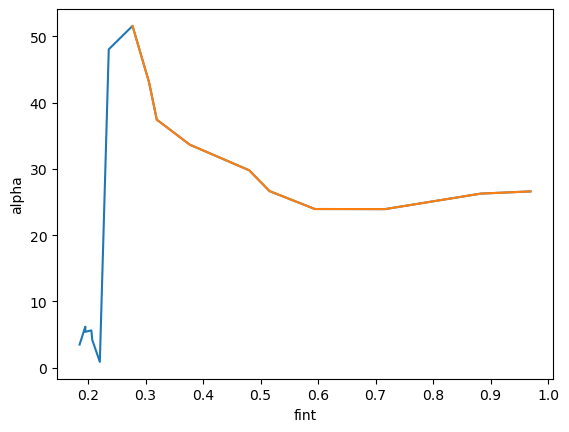

8040


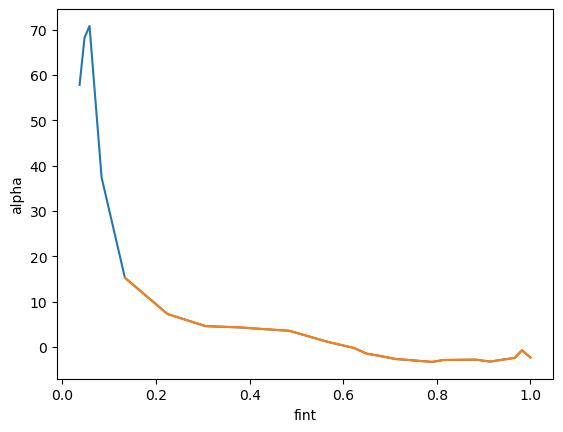

8052


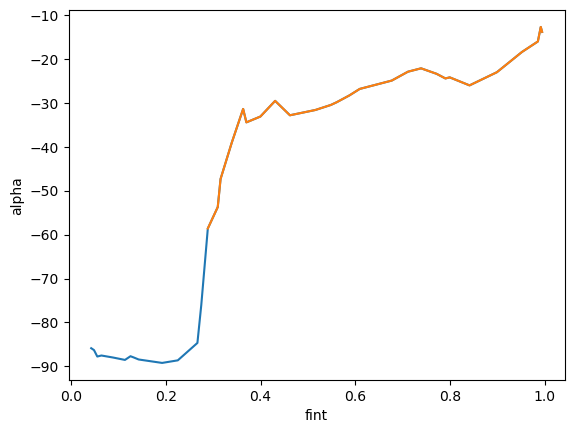

8056


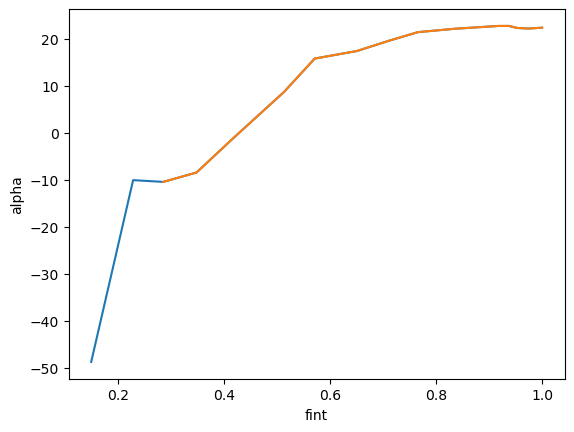

8088


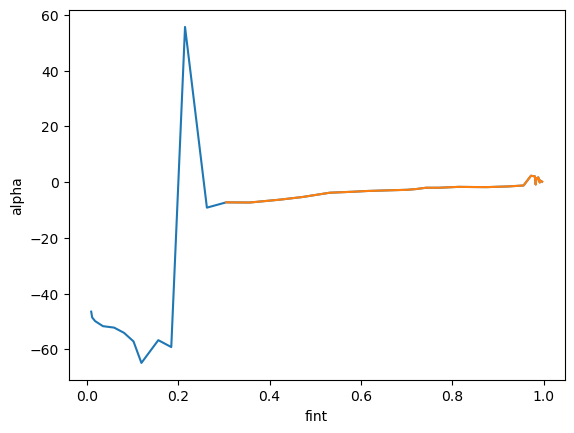

8122


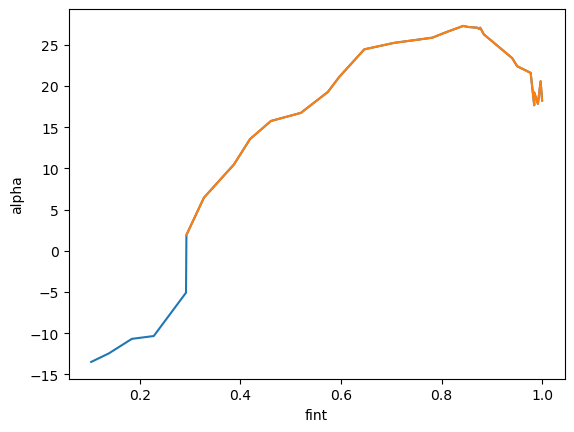

8130


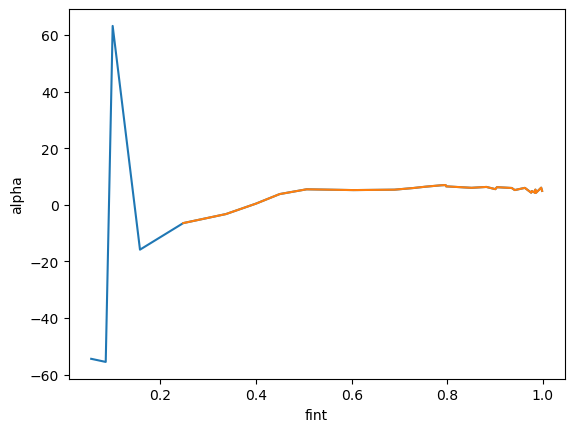

8171


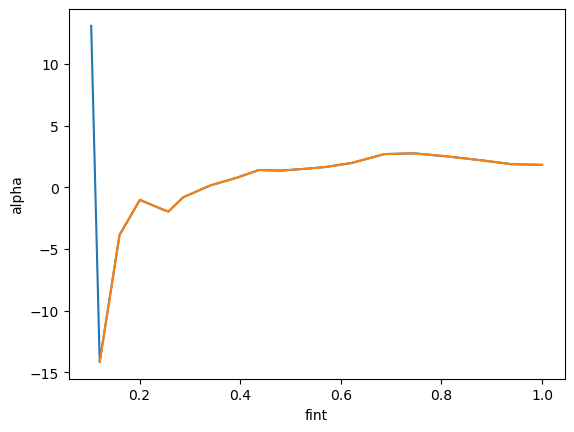

8226


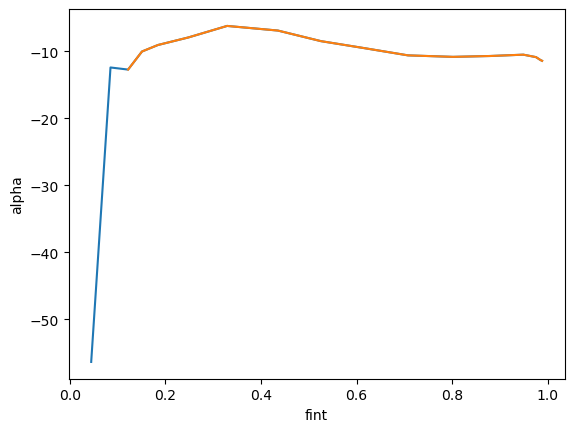

8404


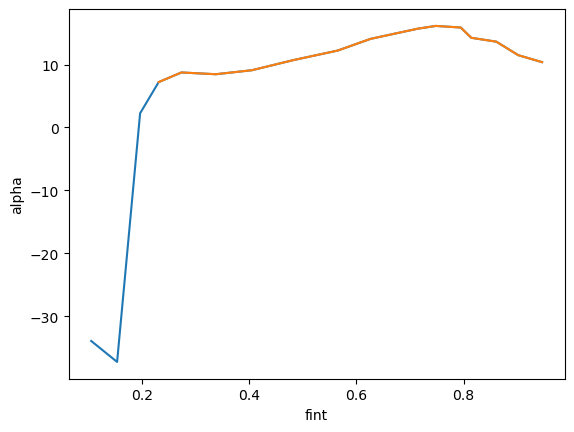

8552


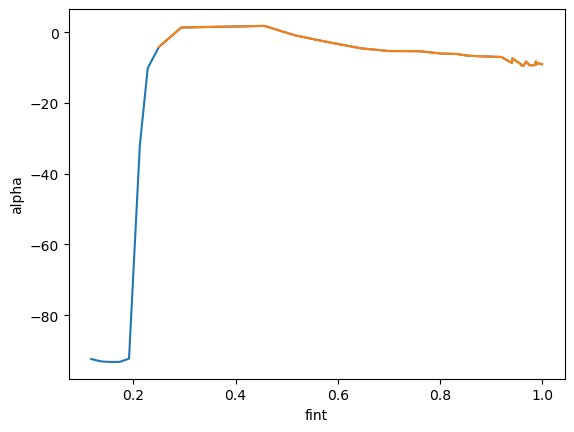

8589


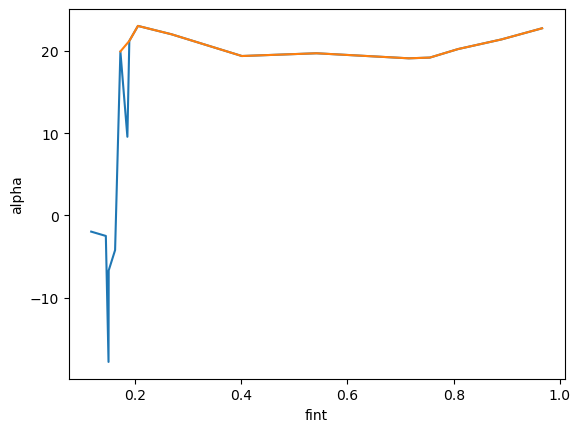

8628


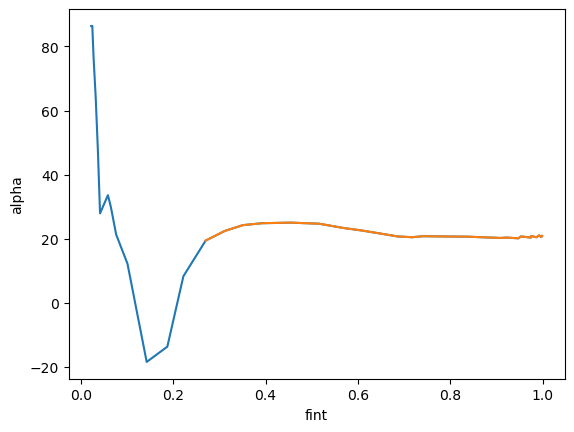

8649


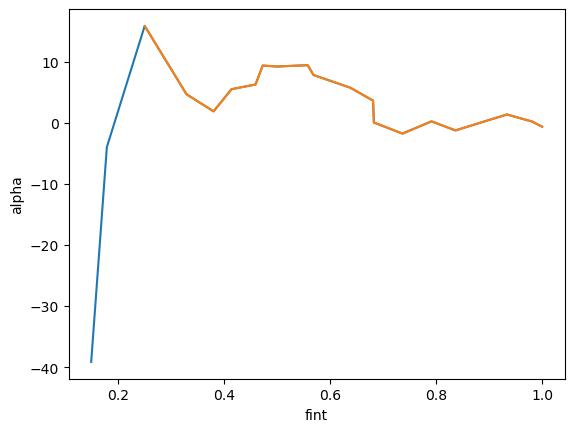

8699


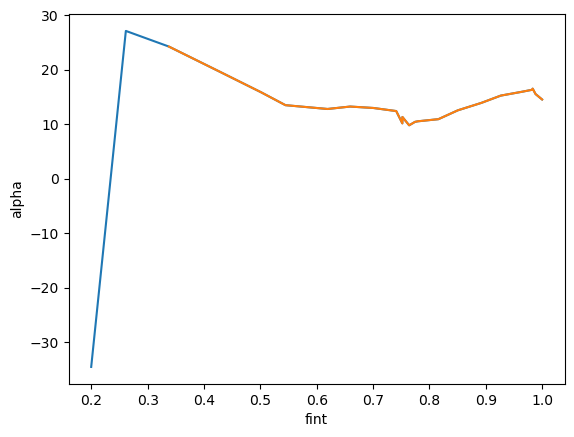

8851


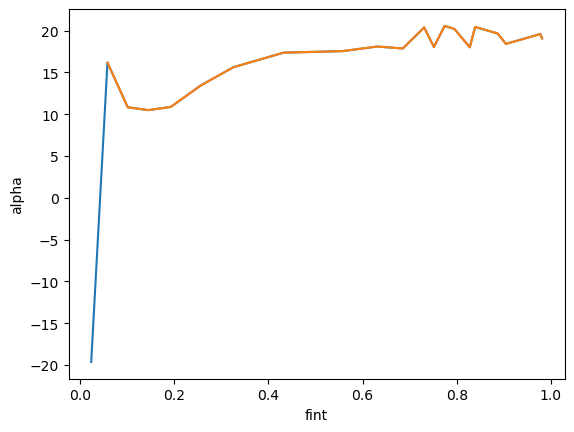

8968


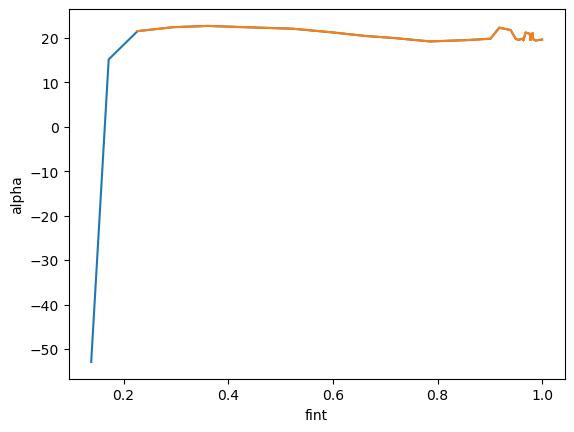

9063


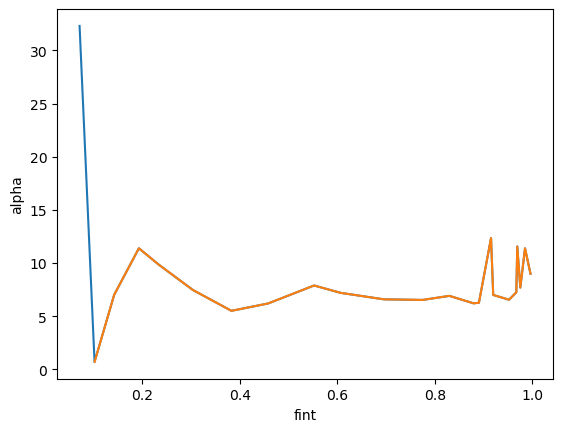

9139


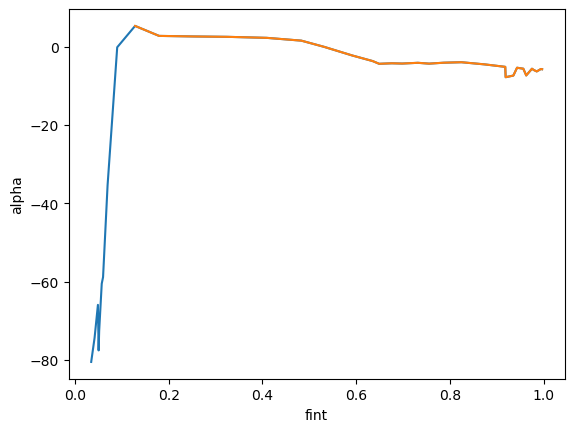

9308


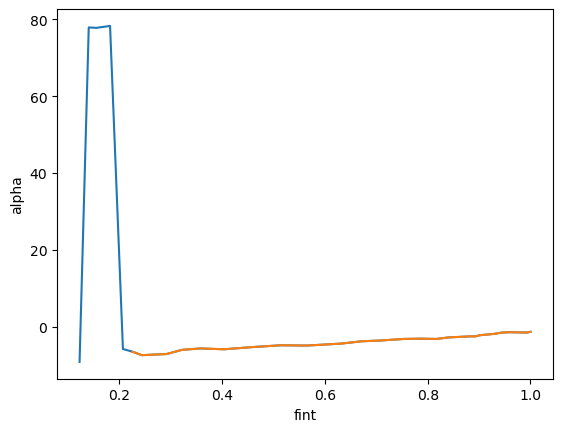

9368


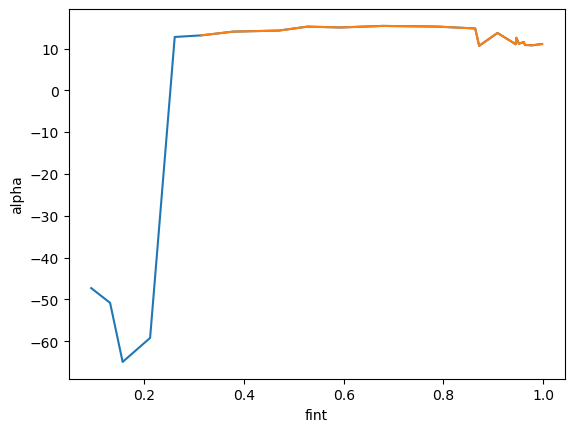

9396


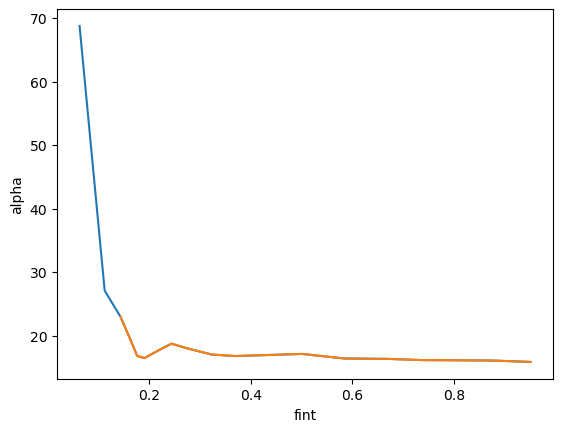

9417


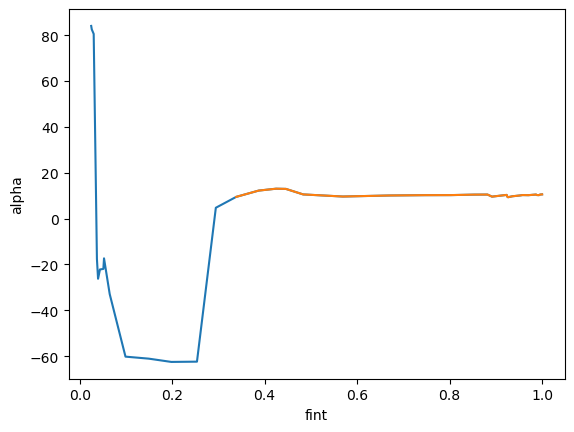

9574


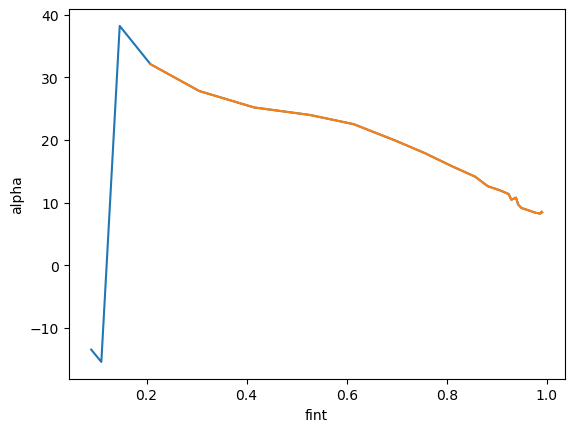

9660


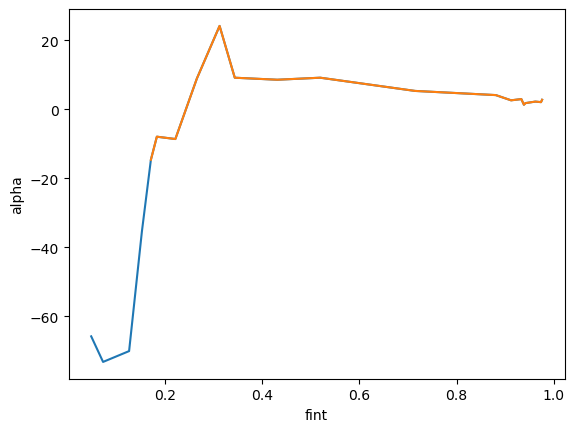

9678


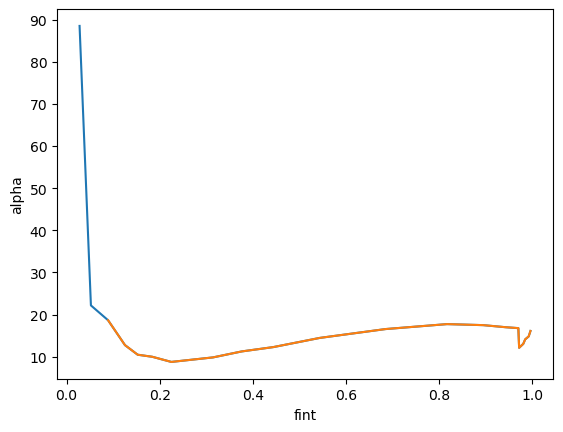

9710


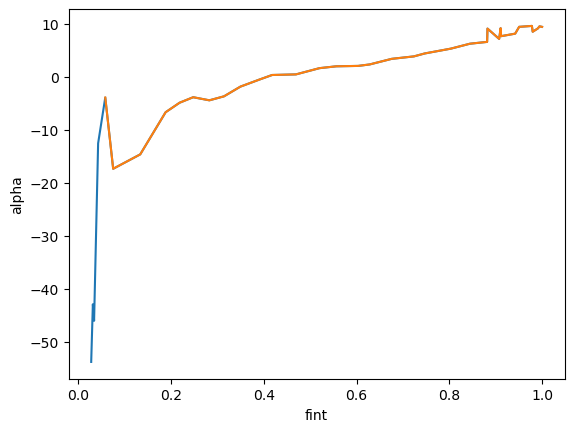

9884


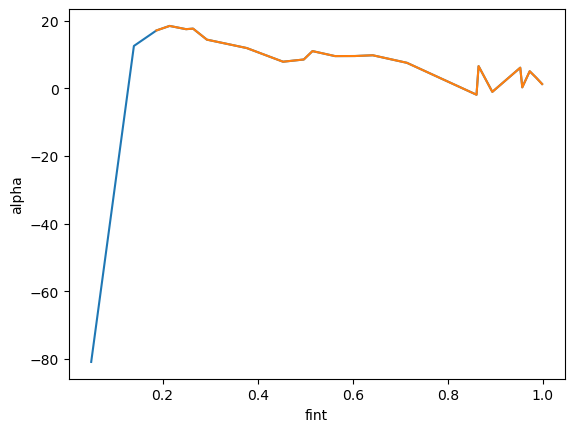

10130


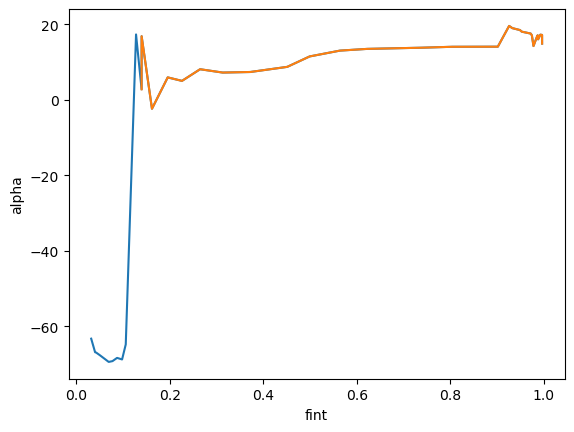

10137


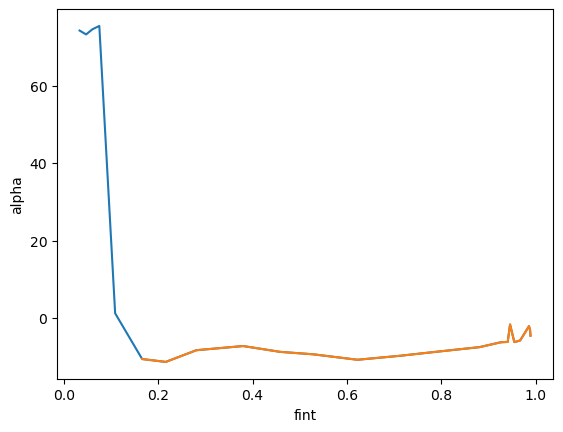

10311


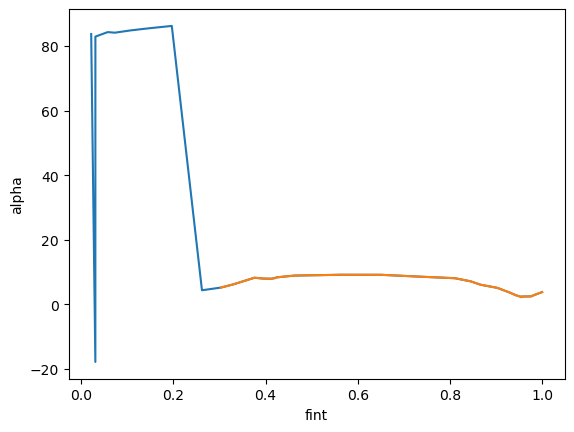

10391


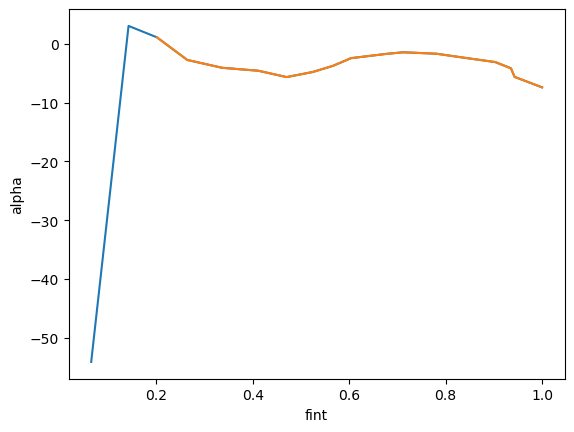

10971


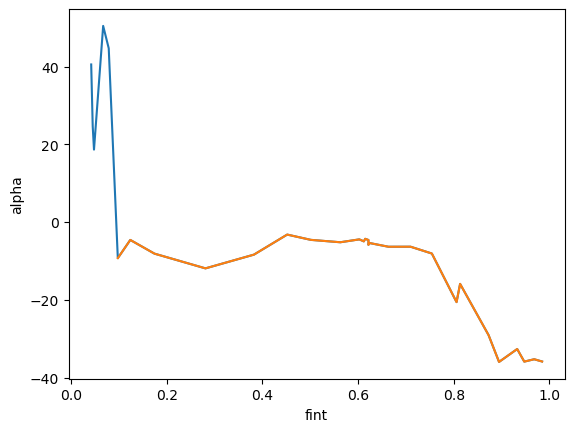

10987


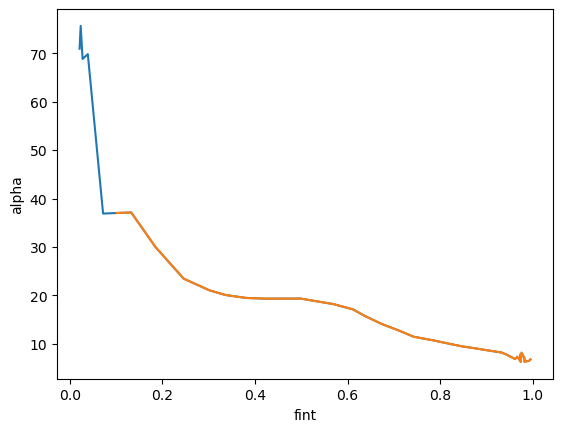

11007


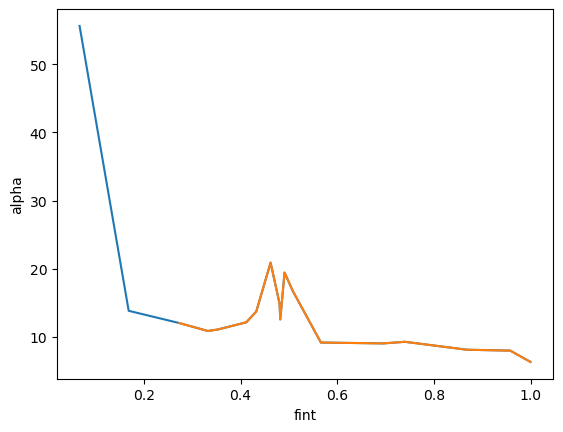

In [15]:
DFxx=[]

#Analize ARs with large rotation, an cut first part of the emergence to reduce their number.

for name in listar:
    DF2 = DF[DF.AR == name]

    #if DF2.fint.min() >= lower_lim:
    #    print(f"Región {name} no llega a f_norm = {lower_lim}, se excluye.")
    #    continue
    
    limax=DF2[np.abs(DF2.rot)>4].max().mag
    DFmax=np.abs(DF2).groupby('AR').max().reset_index()
    
    if (np.abs(DFmax.rot.values) >4) & (DF2[DF2.mag==limax].fint.values <=0.3):
        print(name)
        sns.lineplot(data=DF2,x='fint',y='alpha')
        sns.lineplot(data=DF2[DF2.mag>limax],x='fint',y='alpha')

       # sns.lineplot(data=DF2,x='fint',y='alphab')
        plt.show()

        DFxx.append(DF2[DF2.mag>limax])
    
DFxx=pd.concat(DFxx)


In [16]:
ars2=list(set(listar)^set(ars))

In [17]:
len(ars2)

73

In [18]:
DFb=pd.concat([DFxx,DF[DF['AR'].isin(ars2)]])
len(list(set(DFb.AR.values)))

108

In [19]:
len(ars2)

73

AR 10344 t_norm 0 is lower than 0 ***0.09189180341489027***


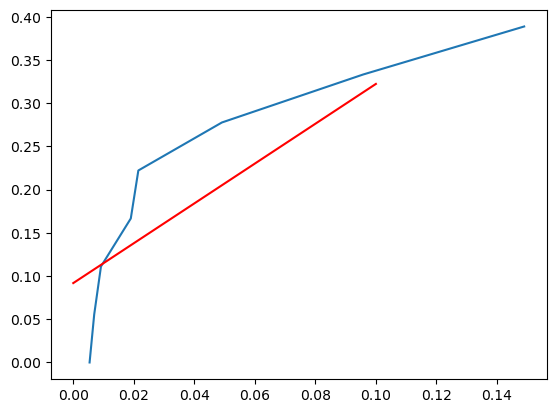

AR 9368 t_norm 0 is lower than 0 ***0.052951162165192495***


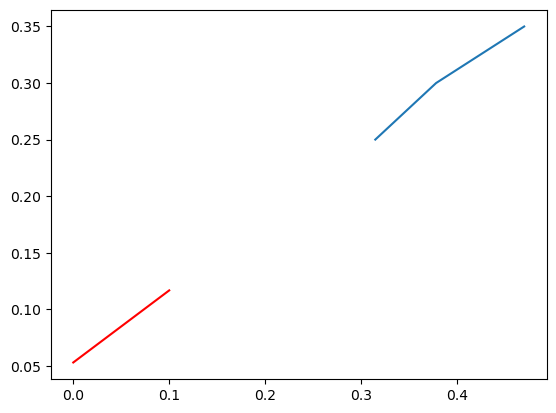

AR 9417 t_norm 0 is lower than 0 ***0.1373273494888459***


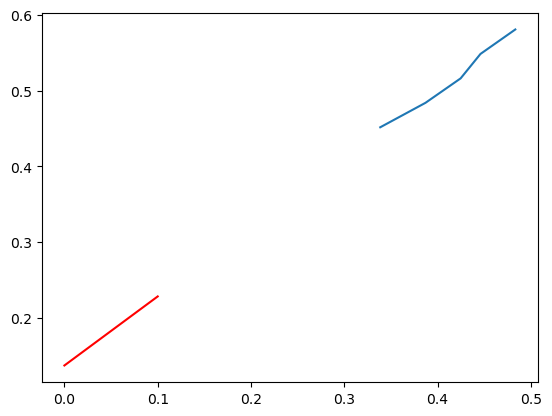

AR 10971 t_norm 0 is lower than 0 ***0.14540819848055878***


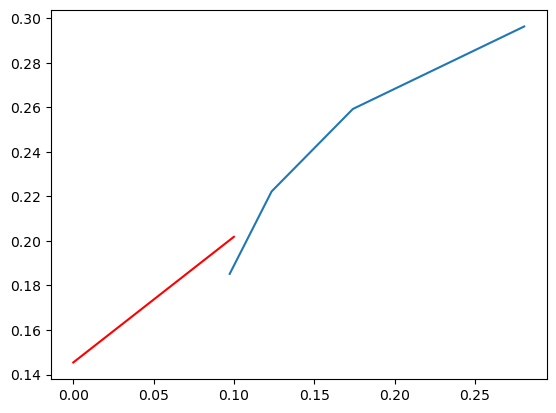

AR 10987 t_norm 0 is lower than 0 ***0.10815334394154155***


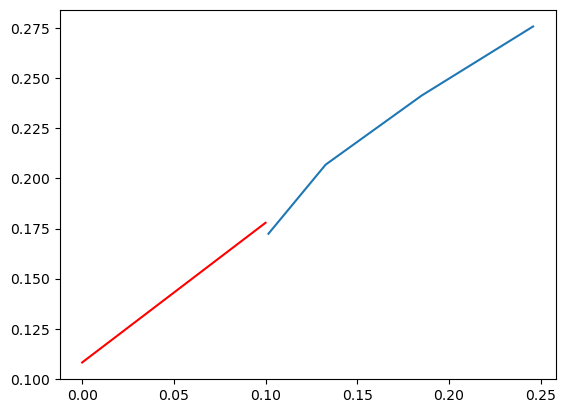

AR 9574 t_norm 0 is lower than 0 ***0.03787605743372906***


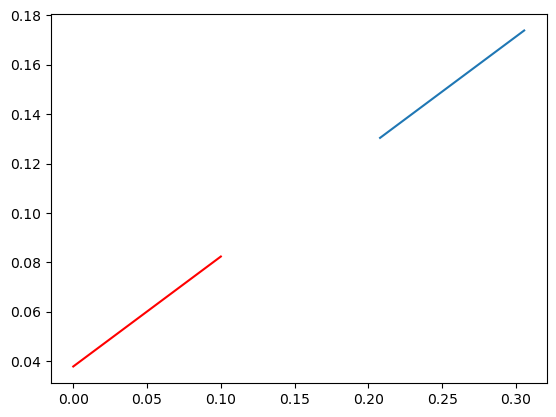

AR 8040 t_norm 0 is lower than 0 ***0.1352736625519628***


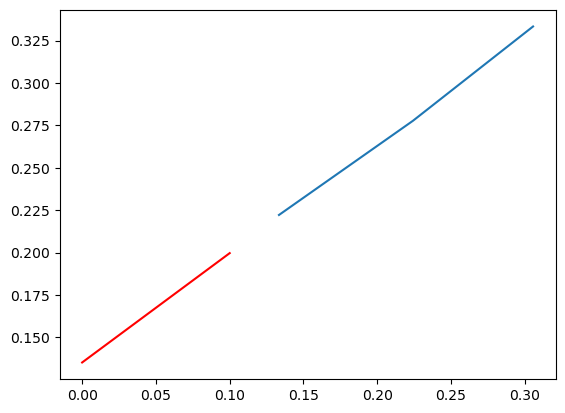

AR 8552 t_norm 0 is lower than 0 ***0.08790873278572012***


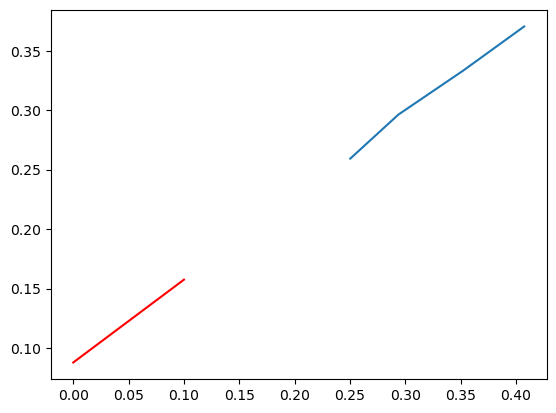

AR 8052 t_norm 0 is lower than 0 ***0.000670058244177707***


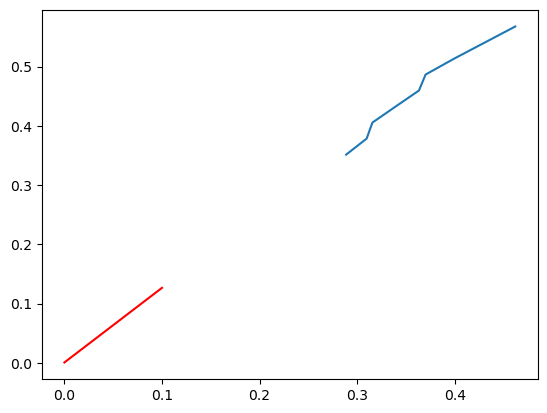

AR 8589 t_norm 0 is lower than 0 ***0.1314866173545033***


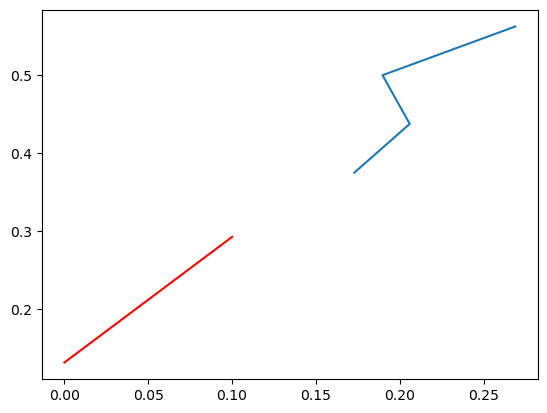

AR 10130 t_norm 0 is lower than 0 ***0.23876856232573163***


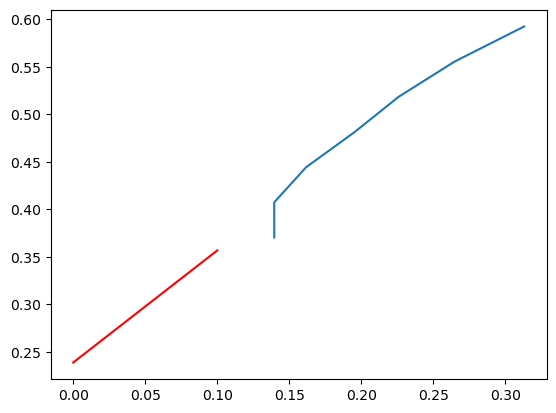

AR 8088 t_norm 0 is lower than 0 ***0.21445182322265485***


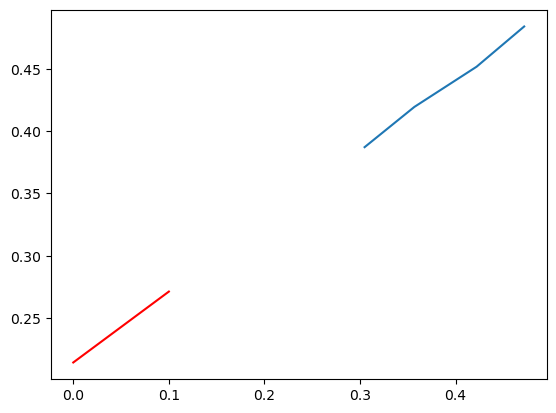

AR 10137 t_norm 0 is lower than 0 ***0.1152344276812477***


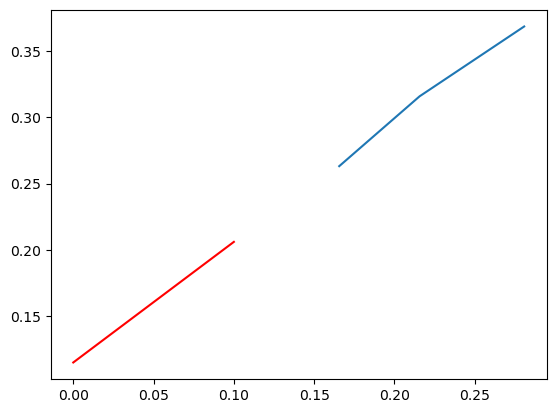

AR 9139 t_norm 0 is lower than 0 ***0.23141906704031465***


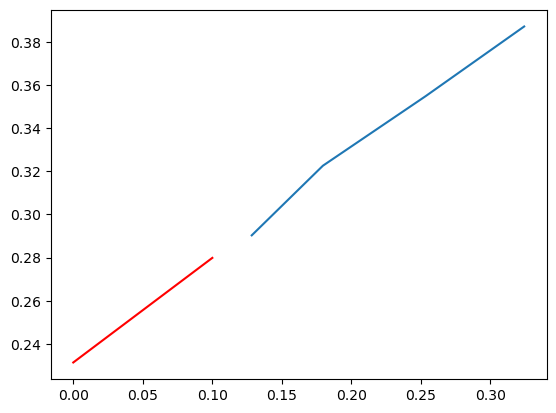

AR 8628 t_norm 0 is lower than 0 ***0.20976602309801953***


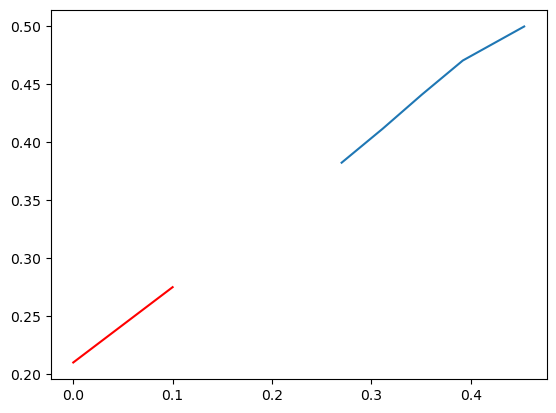

AR 8130 t_norm 0 is lower than 0 ***0.030634762319307812***


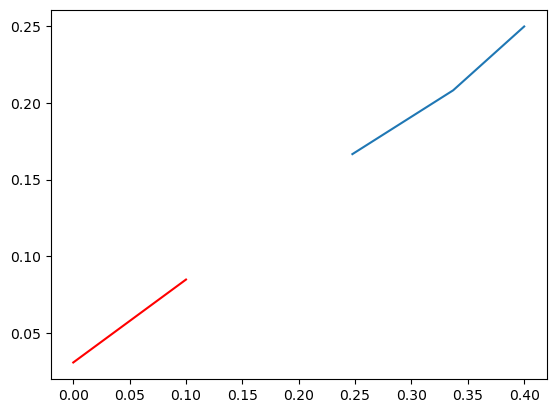

AR 9710 t_norm 0 is lower than 0 ***0.09130091139203984***


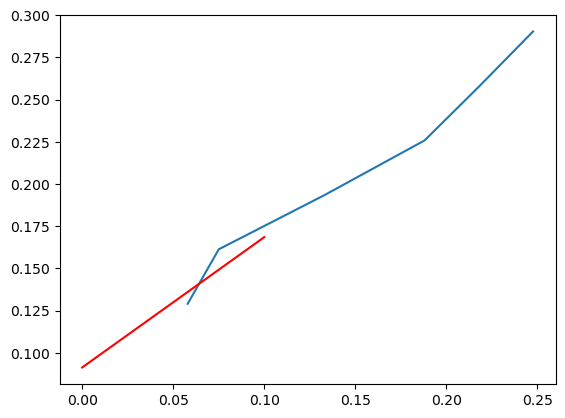

In [20]:
tilta = []
tiltb = []

lower_lim = 0.5
DFx = []

time_grid = np.linspace(0, 1.0, 11)  # Grilla común

#for name in ars2:
for name in list(set(DFb.AR.values)):
    
    DF2 = DFb[DFb.AR == name]

    #if DF2.fint.min() >= lower_lim:
    #    print(f"Región {name} no llega a f_norm = {lower_lim}, se excluye.")
    #    continue
    
    lower_lim =   DF2.fint.min()+0.2
    # Normalización basada en el valor de mag en el punto de máximo flujo normalizado
    idx_max = DF2.fint.idxmax()
    magmax = DF2.loc[idx_max].mag

    # (opcional) linealizar si se desea ajustar f_norm como función de mag/magmax
    DF2p = DF2[DF2.fint < lower_lim]
    x_pre = DF2p.mag.values / magmax
    y_pre = DF2p.fint.values

    slope, intercept, _, _, _ = stats.linregress(y_pre, x_pre)

    # Definir eje de tiempo normalizado
    t_norm = (DF2.mag.values - intercept) / (magmax - intercept)
    
    if intercept >0:
        print(f'AR {name} t_norm 0 is lower than 0 ***{intercept}***')
        plt.plot(y_pre,x_pre)
        plt.plot(np.arange(0,0.2,0.1),slope*np.arange(0,0.2,0.1)+intercept,color='r')
        plt.show()
        
        
 #   DFx.append(pd.DataFrame({'AR':name,'fn':int_fn(time_grid),
 #                            'alpha':int_alpha(time_grid),'alphab':int_alphab(time_grid),'t_grid':time_grid,'t_norm':np.linspace(0,1,11),'lat':DF2.lat.mean()}))
    tilta.append(DF2.alpha.values)
    tiltb.append(DF2.alphab.values)

    DFx.append(pd.DataFrame({'AR':name,'alpha':DF2.alpha.values,'alphab':DF2.alphab.values,'t_norm':t_norm,
                             'lat':DF2.lat.mean(),'fn':DF2.fint.values,'mag':DF2.mag.values,'flux':DF2.flux.values}))

DFx=pd.concat(DFx)

In [21]:
len(tilta)

108

In [22]:
tilta = []
tiltb = []

lower_lim = 0.3
DFx0 = []

time_grid = np.linspace(0, 1.0, 11)  # Grilla común

for name in ars0:
    DF0[DF0.AR == name]=DF0[DF0.AR == name].assign(fint=DF0[DF0.AR == name].flux/np.max(DF0[DF0.AR == name].flux))

    DF2 = DF0[DF0.AR == name]

    if DF2.fint.min() >= lower_lim:
        print(f"Región {name} no llega a f_norm = {lower_lim}, se excluye.")
        continue

    # Normalización basada en el valor de mag en el punto de máximo flujo normalizado
    idx_max = DF2.fint.idxmax()
    magmax = DF2.loc[idx_max].mag

    # (opcional) linealizar si se desea ajustar f_norm como función de mag/magmax
    DF2p = DF2[DF2.fint < lower_lim]
    x_pre = DF2p.mag.values / magmax
    y_pre = DF2p.fint.values

    slope, intercept, _, _, _ = stats.linregress(y_pre, x_pre)

    # Definir eje de tiempo normalizado
    t_norm = (DF2.mag.values - intercept) / (magmax - intercept)

    # Interpolación del tilt (alpha) en función de t_norm
    try:
        int_alpha = interp1d(t_norm, DF2.alpha.values, bounds_error=False, fill_value=np.nan)
        int_alphab = interp1d(t_norm, DF2.alphab.values, bounds_error=False, fill_value=np.nan)
        int_fn=interp1d(t_norm, DF2.fint, bounds_error=False, fill_value=np.nan)

     #   tilta.append(int_alpha(time_grid))
     #   tiltb.append(int_alphab(time_grid))
    except Exception as e:
        print(f"Interpolación fallida en región {name}: {e}")
        
 #   DFx.append(pd.DataFrame({'AR':name,'fn':int_fn(time_grid),
 #                            'alpha':int_alpha(time_grid),'alphab':int_alphab(time_grid),'t_grid':time_grid,'t_norm':np.linspace(0,1,11),'lat':DF2.lat.mean()}))
    tilta.append(DF2.alpha.values)
    tiltb.append(DF2.alphab.values)

    DFx0.append(pd.DataFrame({'AR':name,'alpha':DF2.alpha.values,'alphab':DF2.alphab.values,'t_norm':t_norm,
                             'lat':DF2.lat.mean(),'fn':DF2.fint.values}))

DFx0=pd.concat(DFx0)

Región 9873 no llega a f_norm = 0.3, se excluye.


Región 9032 no llega a f_norm = 0.3, se excluye.


In [23]:
DFx0b=pd.DataFrame({'t_norm':DFx0.t_norm.values,'lat':DFx0.lat.values,'AR':DFx0.AR.values,
                    'fn':DFx0.fn.values,'variable':'alpha0','value':DFx0.alpha.values})[::3]

In [24]:
DFx

AR      alpha     alphab    t_norm   lat        fn   mag          flux
0    8193  55.413941  17.580973  0.001103 -22.0  0.050234   0.0  5.281523e+20
1    8193  52.658806  17.694912  0.067696 -22.0  0.066990   4.0  7.043322e+20
2    8193  26.857078  15.790828  0.134289 -22.0  0.107903   8.0  1.134488e+21
3    8193  20.252607   9.252872  0.200882 -22.0  0.143195  12.0  1.505539e+21
4    8193  19.019187   9.131157  0.267475 -22.0  0.195707  16.0  2.057652e+21
..    ...        ...        ...       ...   ...       ...   ...           ...
15  10747  -2.532979  -2.883163  0.790109  -7.0  0.609831  45.0  4.781975e+21
16  10747  -3.766676  -2.948410  0.842582  -7.0  0.715223  48.0  5.608403e+21
17  10747  -8.162120  -3.470280  0.895055  -7.0  0.802347  51.0  6.291583e+21
18  10747  -8.328748  -2.716777  0.947527  -7.0  0.911246  54.0  7.145513e+21
19  10747  -3.312615  -1.507657  1.000000  -7.0  0.981142  57.0  7.693606e+21

[2845 rows x 8 columns]

In [25]:
DFx2=DFx.assign(frac=lambda x: np.sign(x.alpha*x.alphab)*np.abs(x.alpha-x.alphab)/np.abs(x.alphab))
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)

# Plots for norm time

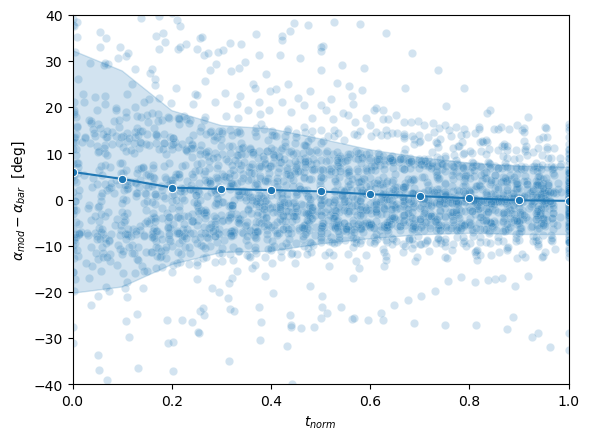

KeyboardInterrupt: 

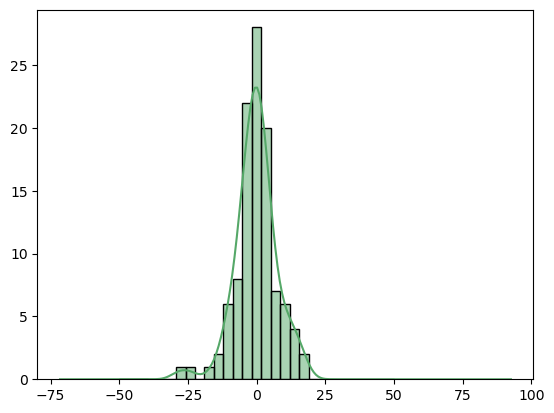

In [25]:

DFx2=DFx.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)


g=sns.scatterplot(data=DFx2,x='t_norm',y='frac',alpha=0.2)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
g=sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)
#   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')
plt.xlim(0,1)
plt.ylim(-40,40)

plt.ylabel(r'$\alpha_{mod}-\alpha_{bar}$  [deg]')
plt.xlabel(r'$t_{norm}$')
plt.show()


sns.histplot(data=DFx2[DFx2.t_mean.isin([0.1,0.5,0.9])],x='frac',hue='t_mean',palette='deep',
             binrange=(-50,50)
             ,kde=True,multiple='layer')

plt.xlim(-50,50)
plt.xlabel(r'$\alpha_{mod}-\alpha_{bar}$  [deg]')

plt.show()


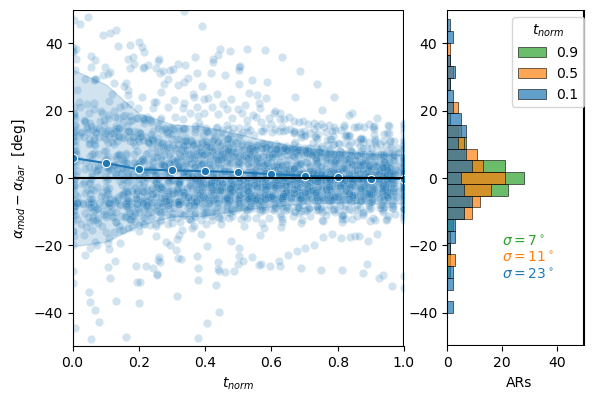

In [ ]:
DFx2=DFx.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='t_norm',
    y='frac',
    kind='scatter',
    alpha=0.2,
    marginal_kws={'bins': 30, 'fill': True},ratio=2,height=6,space=0.3
)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.clear()
hist=sns.histplot(DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])],y='frac',
             hue='t_mean',palette=['tab:blue','tab:orange','tab:green'],
             alpha=0.7,ax=g.ax_marg_y)

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.9','0.5','0.1'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
#hist.legend(handles=handles,labels=labels,title=r'$t_{norm}$')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
g.ax_marg_y.set_xlabel('ARs')
g.ax_joint.plot([0,1],[50,50],color='black')
g.ax_joint.plot([1,1],[-50,50],color='black')
g.ax_marg_y.plot([0,50],[-50,-50],color='black')
g.ax_marg_y.plot([0,50],[50,50],color='black')
g.ax_marg_y.plot([50,50],[-50,50],color='black')


#g.ax_marg_y.legend(handles,['0.1','0.5','0.9'],title=r'$t_{norm}$')
g.ax_marg_y.set_ylim(-50, 50)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(-50, 50)

stds=DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])].groupby('t_mean').std()['frac'].values

g.ax_marg_y.text(20,-30,rf'$\sigma=${stds[0]:.0f}$^\circ$',color='tab:blue')
g.ax_marg_y.text(20,-25,rf'$\sigma=${stds[1]:.0f}$^\circ$',color='tab:orange')
g.ax_marg_y.text(20,-20,rf'$\sigma=${stds[2]:.0f}$^\circ$',color='tab:green')

g.ax_joint.axhline(0,color='black')
g.set_axis_labels(r'$t_{norm}$', r'$\alpha_{mod}-\alpha_{bar}$  [deg]')

plt.savefig('./plots/errorhist.pdf',dpi=300)


In [28]:
set(DFx2.t_mean.values)

{0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0}

63
22
10
5


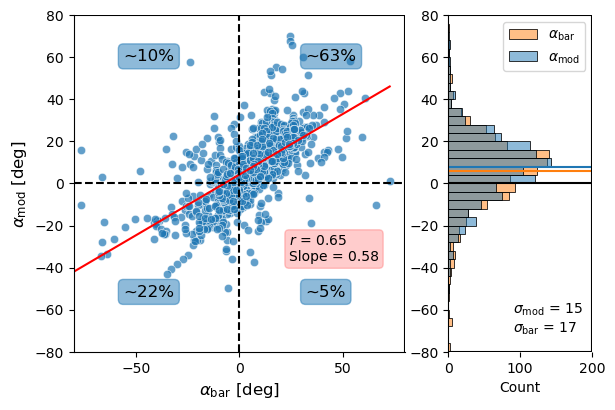

In [54]:
DFx2=DFx.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
DFx2=DFx2[DFx2.t_mean<=1]
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='alphab',
    y='alpha',
    kind='scatter',
    alpha=0.7,
    marginal_kws={'bins': 30,'binrange':(-80,80), 'fill': True},
    ratio=2,height=6,space=0.3
)

g.set_axis_labels(r'$\alpha_\mathrm{bar}$ [deg]',r'$\alpha_\mathrm{mod}$ [deg]', fontsize=12)

g.ax_marg_x.set_visible(False)
#g.ax_marg_y.set_visible(False)
g.ax_marg_x.clear()
g.ax_marg_y.clear()
g.ax_marg_x.set_xlabel('X axis label')
g.ax_marg_y.set_ylabel('Y axis label')
g.ax_marg_x.tick_params(axis='x', labelsize=12)
g.ax_marg_y.tick_params(axis='y', labelsize=12)

hist=sns.histplot(data=pd.melt(DFx2,id_vars=['t_norm','lat','AR','fn','mag','flux'],value_vars=['alpha','alphab']),y='value',
                  hue='variable',
             palette=['tab:blue','tab:orange'],
             alpha=0.5,ax=g.ax_marg_y,binrange=(-80,80),bins=40)

# Linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(DFx2['alphab'], DFx2['alpha'])

# Add linear fit line
x_fit = np.linspace(DFx2['alphab'].min(), DFx2['alphab'].max(), 100)
y_fit = slope * x_fit + intercept
g.ax_joint.plot(x_fit, y_fit, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Annotate with correlation coefficient and slope
g.ax_joint.text(
    0.65, 0.35,
    f'$r$ = {r_value:.2f}\nSlope = {slope:.2f}',
    transform=g.ax_joint.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.2, color='red')
)

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title='',labels=[r'$\alpha_\mathrm{bar}$',r'$\alpha_\mathrm{mod}$'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
#hist.legend(handles=handles,labels=labels,title=r'$t_{norm}$')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
#
g.ax_marg_y.tick_params(axis='y', labelsize=10)  # Set y-ticklabel fontsize
g.ax_marg_y.tick_params(axis='x', labelsize=10)  # Set x-ticklabel fontsize (if needed)

g.ax_marg_y.axhline(0,color='black')

g.ax_marg_y.axhline(DFx2.alpha.mean(),color='tab:blue')
g.ax_marg_y.axhline(DFx2.alphab.mean(),color='tab:orange')

g.ax_joint.axvline(0,color='black',linestyle='dashed')
g.ax_joint.axhline(0,color='black',linestyle='dashed')
g.ax_joint.set_ylim(-80, 80)
g.ax_joint.set_xlim(-80, 80)

g.ax_marg_y.text(
    0.45, 0.15,
    f'$\sigma_\mathrm{{mod}}$ = {DFx2.alpha.std():.0f}\n$\sigma_\mathrm{{bar}}$ = {DFx2.alphab.std():.0f}',
    transform=g.ax_marg_y.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.0, color='red')
)

g.ax_marg_y.set_xlim(0,200)

g.ax_joint.plot([-80,80],[80,80],color='black')
g.ax_joint.plot([80,80],[-80,80],color='black')
g.ax_marg_y.plot([0,200],[-80,-80],color='black')
g.ax_marg_y.plot([0,200],[80,80],color='black')
g.ax_marg_y.plot([200,200],[-80,80],color='black')


aa=DFx2.alpha.values
ab=DFx2.alphab.values



print(round(100*sum((aa>0)*(ab>0))/len(aa)))
print(round(100*sum((aa<0)*(ab<0))/len(aa)))
print(round(100*sum((aa>0)*(ab<0))/len(aa)))
print(round(100*sum((aa<0)*(ab>0))/len(aa)))

g.ax_joint.text(0.7,0.9,f'~{round(100*sum((aa>0)*(ab>0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.15,0.9,f'~{round(100*sum((aa>0)*(ab<0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.7,0.2,f'~{round(100*sum((aa<0)*(ab>0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.15,0.2,f'~{round(100*sum((aa<0)*(ab<0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
plt.savefig('./plots/alpha-alpha.pdf',dpi=300)


In [55]:
aa=DFx2.alpha.values
ab=DFx2.alphab.values



print(round(100*sum((aa>0)*(ab>0))/len(aa)))
print(round(100*sum((aa<0)*(ab<0))/len(aa)))
print(round(100*sum((aa>0)*(ab<0))/len(aa)))
print(round(100*sum((aa<0)*(ab>0))/len(aa)))



print(len(aa))


63
22
10
5
1111


In [48]:
DFx2=DFx.assign(frac=lambda x: np.abs(x.alpha-x.alphab))
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='t_norm',
    y='frac',
    kind='scatter',
    alpha=0.2,
    marginal_kws={'bins': 30, 'fill': True},ratio=2,height=6,space=0.3
)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.clear()
hist=sns.histplot(DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])],y='frac',
             hue='t_mean',palette=['tab:blue','tab:orange','tab:green'],
             alpha=0.7,ax=g.ax_marg_y)

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.9','0.5','0.1'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
#hist.legend(handles=handles,labels=labels,title=r'$t_{norm}$')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
g.ax_marg_y.set_xlabel('ARs')
g.ax_joint.plot([0,1],[50,50],color='black')
g.ax_joint.plot([1,1],[0,50],color='black')
g.ax_marg_y.plot([0,50],[0,0],color='black')
g.ax_marg_y.plot([0,50],[50,50],color='black')
g.ax_marg_y.plot([50,50],[0,50],color='black')


#g.ax_marg_y.legend(handles,['0.1','0.5','0.9'],title=r'$t_{norm}$')
g.ax_marg_y.set_ylim(0, 50)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(0, 50)

stds=DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])].groupby('t_mean').std()['frac'].values
means=DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])].groupby('t_mean').mean()['frac'].values


g.ax_marg_y.text(10,24,rf'$\mu=${means[0]:.0f}$^\circ$, $\sigma=${stds[0]:.0f}$^\circ$',color='tab:blue')
g.ax_marg_y.text(10,27,rf'$\mu=${means[1]:.0f}$^\circ$, $\sigma=${stds[1]:.0f}$^\circ$',color='tab:orange')
g.ax_marg_y.text(10,30,rf'$\mu=${means[2]:.0f}$^\circ$, $\sigma=${stds[2]:.0f}$^\circ$',color='tab:green')

g.ax_joint.axhline(0,color='black')
g.set_axis_labels(r'$t_{norm}$', r'|$\alpha_{mod}-\alpha_{bar}$|  [deg]')

plt.savefig('./plots/errorhistabs.pdf',dpi=300)


In [55]:
sns.scatterplot(data=DFx2,x='alphab',y='alpha',alpha=0.7,color='tab:blue')

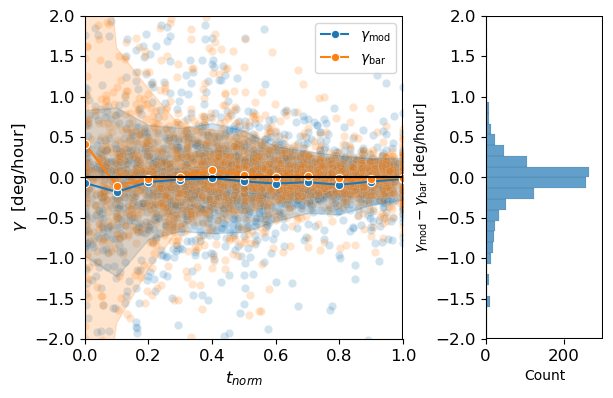

In [79]:
DFx=DFx.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DFx=DFx.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

DFx2=DFx.assign(frac=lambda x: x.rot-x.rotb)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='t_norm',
    y='rot',
    kind='scatter',
    alpha=0.2,
    marginal_kws={'bins': 30, 'fill': True},ratio=2,height=6,space=0.7
)

sns.scatterplot(data=DFx2,x='t_norm',y='rotb',alpha=0.2,color='tab:orange')

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
sns.lineplot(
data=DFx2,
x='t_mean',
y='rot',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o',          # opcional para marcar puntos medios
label=r'$\gamma_\mathrm{mod}$')
sns.lineplot(
data=DFx2,
x='t_mean',
y='rotb',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o',          # opcional para marcar puntos medios
label=r'$\gamma_\mathrm{bar}$'
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.clear()
'''
hist=sns.histplot(DFx2[DFx2['t_mean']<=0.5],y='rot',
             color='tab:blue',
             alpha=0.7,ax=g.ax_marg_y,bins=30,binrange=(-5,5))
hist=sns.histplot(DFx2[DFx2['t_mean']<=0.5],y='rotb',
             color='tab:orange',
             alpha=0.7,ax=g.ax_marg_y,bins=30,binrange=(-5,5))
'''


hist=sns.histplot(DFx2[DFx2['t_mean']<=1],y='frac',
             color='tab:blue',
             alpha=0.7,ax=g.ax_marg_y,bins=30,binrange=(-2,2))

#g.legend(title='',loc='upper right')
#g.ax_marg_y.legend()
#g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.1','0.5','0.9'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel(r'$\gamma_\mathrm{mod}-\gamma_\mathrm{bar}$ [deg/hour]')
g.ax_marg_y.set_xlabel('Count')
g.ax_joint.plot([0,1],[2,2],color='black')
g.ax_joint.plot([1,1],[-2,2],color='black')
g.ax_marg_y.plot([0,300],[-2,-2],color='black')
g.ax_marg_y.plot([0,300],[2,2],color='black')
g.ax_marg_y.plot([300,300],[-2,2],color='black')


#g.ax_marg_y.legend(handles,['0.1','0.5','0.9'],title=r'$t_{norm}$')
g.ax_marg_y.set_ylim(-2, 2)
g.ax_marg_y.set_xlim(0, 300)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(-2, 2)
g.ax_joint.tick_params(axis='both', labelsize=12)
g.ax_marg_y.tick_params(axis='both', labelsize=12)

stds=DFx2[DFx2['t_mean'].isin([0.1])].groupby('t_mean').std()[['rot','rotb']].values

#g.ax_marg_y.text(20,-2,rf'$\sigma=${stds[0][0]:.1f}$^\circ$',color='tab:blue')
#g.ax_marg_y.text(20,-2.5,rf'$\sigma=${stds[0][1]:.1f}$^\circ$',color='tab:orange')

#g.ax_marg_y.legend(handles=handles,title='$t_\mathrm{norm}$',loc='upper right')
g.ax_joint.axhline(0,color='black')
g.set_axis_labels(r'$t_{norm}$', r'$\gamma$  [deg/hour]',fontsize=12)

plt.savefig('./plots/rotations.pdf',dpi=300)


In [84]:
DFx=DFx.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DFx=DFx.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

DFx2=DFx.assign(frac=lambda x: x.rot-x.rotb)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='t_norm',
    y='frac',
    kind='scatter',
    alpha=0.2,
    marginal_kws={'bins': 30, 'fill': True},ratio=2,height=6,space=0.3
)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.clear()
hist=sns.histplot(DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])],y='frac',
             hue='t_mean',palette=['tab:blue','tab:orange','tab:green'],
             alpha=0.7,ax=g.ax_marg_y,bins=30,binrange=(-5,5))

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.1','0.5','0.9'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
g.ax_marg_y.set_xlabel('ARs')
g.ax_joint.plot([0,1],[5,5],color='black')
g.ax_joint.plot([1,1],[-5,5],color='black')
g.ax_marg_y.plot([0,50],[-5,-5],color='black')
g.ax_marg_y.plot([0,50],[5,5],color='black')
#g.ax_marg_y.plot([50,50],[-5,5],color='black')


#g.ax_marg_y.legend(handles,['0.1','0.5','0.9'],title=r'$t_{norm}$')
g.ax_marg_y.set_ylim(-5, 5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(-5, 5)

stds=DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])].groupby('t_mean').std()['frac'].values

g.ax_marg_y.text(20,-2,rf'$\sigma=${stds[0]:.1f}$^\circ$',color='tab:blue')
g.ax_marg_y.text(20,-2.5,rf'$\sigma=${stds[1]:.1f}$^\circ$',color='tab:orange')
g.ax_marg_y.text(20,-3,rf'$\sigma=${stds[2]:.1f}$^\circ$',color='tab:green')

g.ax_joint.axhline(0,color='black')
g.set_axis_labels(r'$t_{norm}$', r'$\gamma_{mod} - \gamma_{bar}$  [deg/hour]')

plt.savefig('./plots/rotdif.pdf',dpi=300)


In [85]:
DFx=DFx.assign(rot= lambda x: np.gradient(x.alpha,x.mag)/1.5)
DFx=DFx.assign(rotb= lambda x: np.gradient(x.alphab,x.mag)/1.5)

DFx2=DFx.assign(frac=lambda x: np.abs(x.rot)-np.abs(x.rotb))
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y
g = sns.jointplot(
    data=DFx2,
    x='t_norm',
    y='frac',
    kind='scatter',
    alpha=0.2,
    marginal_kws={'bins': 30, 'fill': True},ratio=2,height=6,space=0.3
)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
ax=g.ax_joint,
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)

g.ax_marg_x.set_visible(False)
g.ax_marg_y.clear()
hist=sns.histplot(DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])],y='frac',
             hue='t_mean',palette=['tab:blue','tab:orange','tab:green'],
             alpha=0.7,ax=g.ax_marg_y,bins=30,binrange=(-5,5))

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.1','0.5','0.9'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
g.ax_marg_y.set_xlabel('ARs')
g.ax_joint.plot([0,1],[5,5],color='black')
g.ax_joint.plot([1,1],[-5,5],color='black')
g.ax_marg_y.plot([0,50],[-5,-5],color='black')
g.ax_marg_y.plot([0,50],[5,5],color='black')
#g.ax_marg_y.plot([50,50],[-5,5],color='black')


#g.ax_marg_y.legend(handles,['0.1','0.5','0.9'],title=r'$t_{norm}$')
g.ax_marg_y.set_ylim(-5, 5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(-5, 5)

stds=DFx2[DFx2['t_mean'].isin([0.1,0.5,0.9])].groupby('t_mean').std()['frac'].values

g.ax_marg_y.text(20,-2,rf'$\sigma=${stds[0]:.1f}$^\circ$',color='tab:blue')
g.ax_marg_y.text(20,-2.5,rf'$\sigma=${stds[1]:.1f}$^\circ$',color='tab:orange')
g.ax_marg_y.text(20,-3,rf'$\sigma=${stds[2]:.1f}$^\circ$',color='tab:green')

g.ax_joint.axhline(0,color='black')
g.set_axis_labels(r'$t_{norm}$', r'$|\gamma_{mod}| - |\gamma_{bar}|$  [deg/hour]')

plt.savefig('./plots/rotdifabs.pdf',dpi=300)


In [69]:
stds[0][0]

In [73]:

DFx2=DFx.assign(frac=lambda x: 2*np.abs(x.alpha-x.alphab)/np.abs(x.alpha+x.alphab))
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)


g=sns.scatterplot(data=DFx2,x='t_norm',y='frac',alpha=0.2)

DFx2=DFx2.groupby(['AR','t_mean']).mean().reset_index()
g=sns.lineplot(
data=DFx2,
x='t_mean',
y='frac',
estimator='mean',
errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
err_style='band',   # o 'bars' para barras verticales
marker='o'          # opcional para marcar puntos medios
)
#   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')
plt.xlim(0,1)
plt.ylim(0,10)
'''
plt.xlim(0,1)
plt.ylim(-200,200)

plt.ylabel(r'$\alpha / \sin$(lat) [deg]')
plt.xlabel(r'$t_{norm}$')

plt.axhline(0,linestyle='dashed',color='gray')

plt.title(fr'Latitude range: {r[0]}$^\circ -$  {r[1]}$^\circ$')

handles, labels = g.get_legend_handles_labels()

#   plt.legend(title='',handles=handles,labels=labels[:2])

plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'])
plt.show()

'''

# Define DFx1

In [94]:
DFx1=pd.melt(DFx,id_vars=['t_norm','lat','AR','fn','mag','flux'],value_vars=['alpha','alphab'])

In [95]:
#DFx1=pd.concat([DFx1,DFx0b]).reset_index()

In [96]:
DFx1=DFx1.assign(t_mean=lambda x: round(10*x.t_norm)/10)

In [97]:
DFx1['sin_lat'] = np.sin(np.radians(np.abs(DFx1['lat'])))
DFx1['tilt_sinlat'] = DFx1['value'] / DFx1['sin_lat']

In [98]:
DFx1=DFx1.assign(tilt_norm=lambda x: x.value/np.sin(np.pi*np.abs(x.lat)/180))

In [99]:
DFx1 = DFx1[np.abs(DFx1['sin_lat']) > 0.05].copy()

In [100]:
DFx1

t_norm   lat     AR        fn   mag          flux variable      value  \
0     0.001103 -22.0   8193  0.050234   0.0  5.281523e+20    alpha  55.413941   
1     0.067696 -22.0   8193  0.066990   4.0  7.043322e+20    alpha  52.658806   
2     0.134289 -22.0   8193  0.107903   8.0  1.134488e+21    alpha  26.857078   
3     0.200882 -22.0   8193  0.143195  12.0  1.505539e+21    alpha  20.252607   
4     0.267475 -22.0   8193  0.195707  16.0  2.057652e+21    alpha  19.019187   
...        ...   ...    ...       ...   ...           ...      ...        ...   
5685  0.790109  -7.0  10747  0.609831  45.0  4.781975e+21   alphab  -2.883163   
5686  0.842582  -7.0  10747  0.715223  48.0  5.608403e+21   alphab  -2.948410   
5687  0.895055  -7.0  10747  0.802347  51.0  6.291583e+21   alphab  -3.470280   
5688  0.947527  -7.0  10747  0.911246  54.0  7.145513e+21   alphab  -2.716777   
5689  1.000000  -7.0  10747  0.981142  57.0  7.693606e+21   alphab  -1.507657   

      t_mean   sin_lat  tilt_sinlat   tilt_norm  
0        0.0  0.374607   147.925696  147.925696  
1        0.1  0.374607   140.570953  140.570953  
2        0.1  0.374607    71.694088   71.694088  
3        0.2  0.374607    54.063670   54.063670  
4        0.3  0.374607    50.771095   50.771095  
...      ...       ...          ...         ...  
5685     0.8  0.121869   -23.657822  -23.657822  
5686     0.8  0.121869   -24.193202  -24.193202  
5687     0.9  0.121869   -28.475415  -28.475415  
5688     0.9  0.121869   -22.292537  -22.292537  
5689     1.0  0.121869   -12.371095  -12.371095  

[5690 rows x 12 columns]

# Filter ouliers

In [102]:
list(set(DFx1.t_mean))[:10]

[0.0, 0.4, 0.3, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [103]:
ARout=[]

for tt in list(set(DFx1.t_mean))[:10]:

    df=DFx1[(DFx1.variable=='alpha') & (DFx1.t_mean==tt)]
    dfar=df.groupby(['AR','variable']).mean().reset_index()
    # Median and MAD
    median_tilt_sinlat = dfar['tilt_sinlat'].median()
    mad_tilt_sinlat = np.median(np.abs(dfar['tilt_sinlat'] - median_tilt_sinlat))

    # Define threshold (e.g., 3 times MAD)
    threshold = 3
    modified_z_scores = 0.6745 * (dfar['tilt_sinlat'] - median_tilt_sinlat) / mad_tilt_sinlat

    # Filter out outliers
    dfar_clean = dfar[np.abs(modified_z_scores) >= threshold].copy()
    
    for names in dfar_clean.AR.values:
        ARout.append(names)

In [104]:
ARout=list(set(ARout))

In [105]:
len(ARout)

19

In [106]:
DFmax=DFx1.groupby(['AR','variable']).max().reset_index()
DFmax['B_bin']=pd.qcut(DFmax['flux'],q=3,labels=['low','medium','high'])
#DFmax['B_bin'] = pd.cut(DFmax['flux'], bins=3, labels=['low', 'medium', 'high']) # for equal lenght bins
DFx1 = DFx1.merge(DFmax[['AR', 'variable', 'B_bin']], on=['AR', 'variable'], how='left')

<AxesSubplot: xlabel='B_bin', ylabel='flux'>

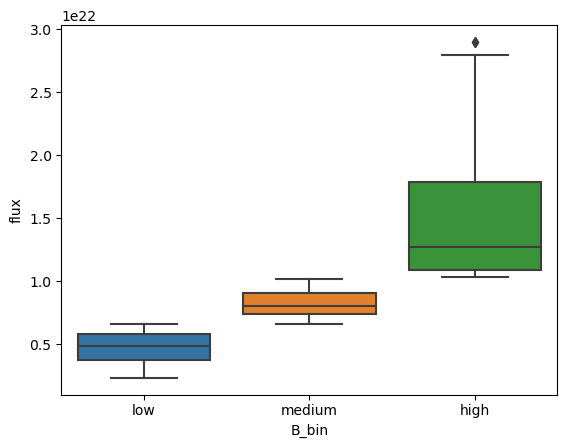

In [107]:
sns.boxplot(DFmax,x='B_bin',y='flux')

# Evolve plots

range: (0, 39) / ARs: 89


/tmp/ipykernel_24233/453164292.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()


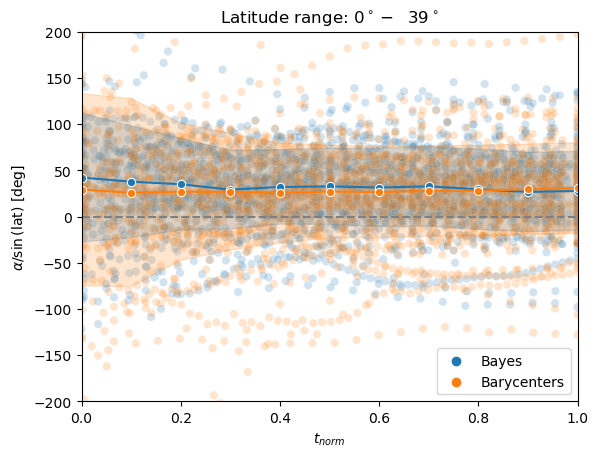

In [108]:
for r in [(0,39)]:
    DFx2=DFx1[(np.abs(DFx1.lat) >= r[0]) & (np.abs(DFx1.lat) < r[1])]

    DFx2 = DFx2[~DFx2['AR'].isin(ARout)].copy()
    print(f'range: {r} / ARs: {len(set(DFx2.AR))}')
    
    g=sns.scatterplot(data=DFx2,x='t_norm',y='tilt_sinlat',hue='variable',alpha=0.2)
    DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()
    g=sns.lineplot(
        data=DFx2,
        x='t_mean',
        y='tilt_sinlat',
        hue='variable',
        estimator='median',
        errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
        err_style='band',   # o 'bars' para barras verticales
        marker='o'          # opcional para marcar puntos medios
    )
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')

    plt.xlim(0,1)
    plt.ylim(-200,200)

    plt.ylabel(r'$\alpha / \sin$(lat) [deg]')
    plt.xlabel(r'$t_{norm}$')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    
    plt.title(fr'Latitude range: {r[0]}$^\circ -$  {r[1]}$^\circ$')
    
    handles, labels = g.get_legend_handles_labels()
    
 #   plt.legend(title='',handles=handles,labels=labels[:2])

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'])
    plt.show()

B range: low / ARs: 36


/tmp/ipykernel_24233/2765926417.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()


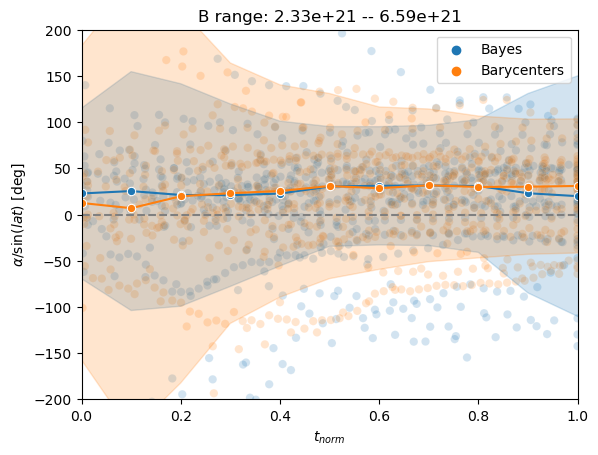

B range: medium / ARs: 36


/tmp/ipykernel_24233/2765926417.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()


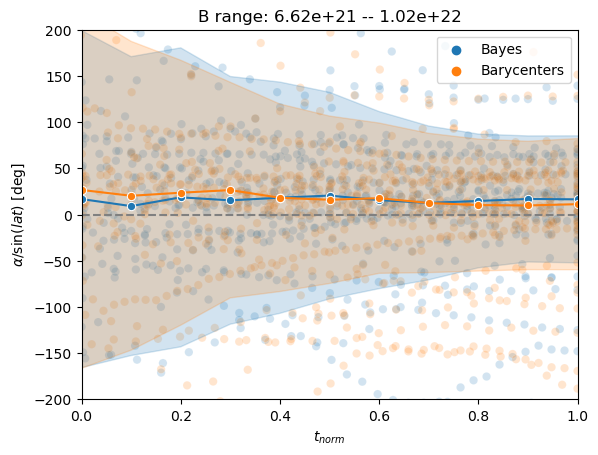

B range: high / ARs: 36


/tmp/ipykernel_24233/2765926417.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()


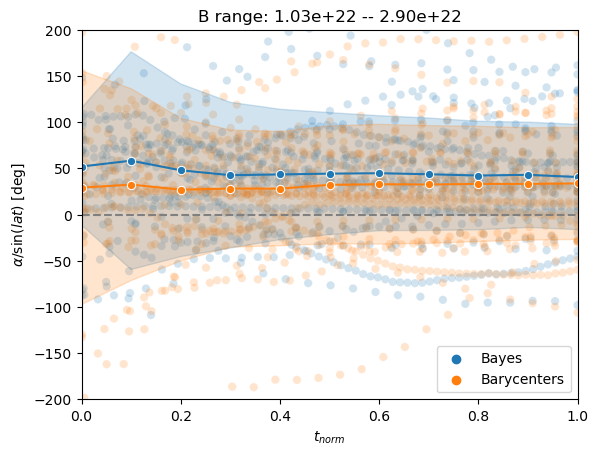

In [109]:
for r in ['low','medium','high']:
    DFx2=DFx1[DFx1.B_bin==r]

   # DFx2 = DFx2[~DFx2['AR'].isin(ARout)].copy()
    print(f'B range: {r} / ARs: {len(set(DFx2.AR))}')
    
    g=sns.scatterplot(data=DFx2,x='t_norm',y='tilt_sinlat',hue='variable',alpha=0.2)
    DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()
    g=sns.lineplot(
        data=DFx2,
        x='t_mean',
        y='tilt_sinlat',
        hue='variable',
        estimator='median',
        errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
        err_style='band',   # o 'bars' para barras verticales
        marker='o'          # opcional para marcar puntos medios
    )
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')

    plt.xlim(0,1)
    plt.ylim(-200,200)

    plt.ylabel(r'$\alpha / \sin(lat)$ [deg]')
    plt.xlabel(r'$t_{norm}$')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    minf=DFmax[DFmax.B_bin==r]['flux'].min()
    maxf=DFmax[DFmax.B_bin==r]['flux'].max()
    plt.title(f'B range: {minf:.2e} -- {maxf:.2e}')
    
    handles, labels = g.get_legend_handles_labels()
    
 #   plt.legend(title='',handles=handles,labels=labels[:2])

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'])
    plt.show()


range: (0, 39) / ARs: 89


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


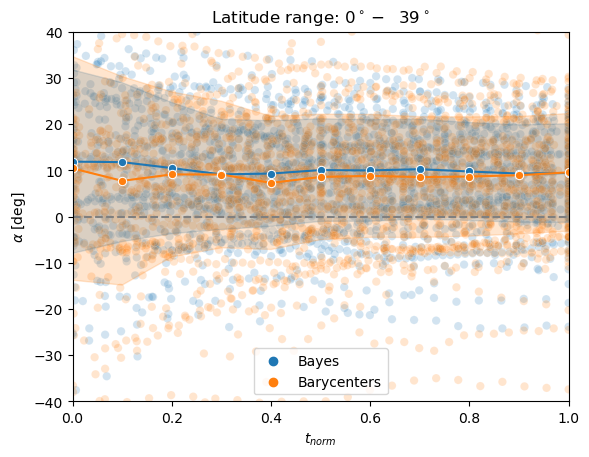

range: (0, 10) / ARs: 11


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


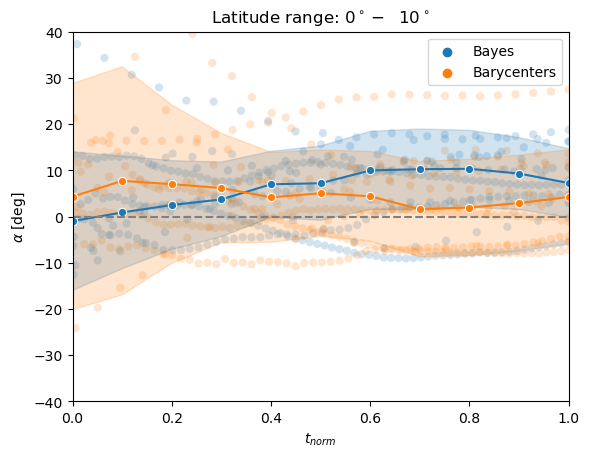

range: (10, 15) / ARs: 17


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


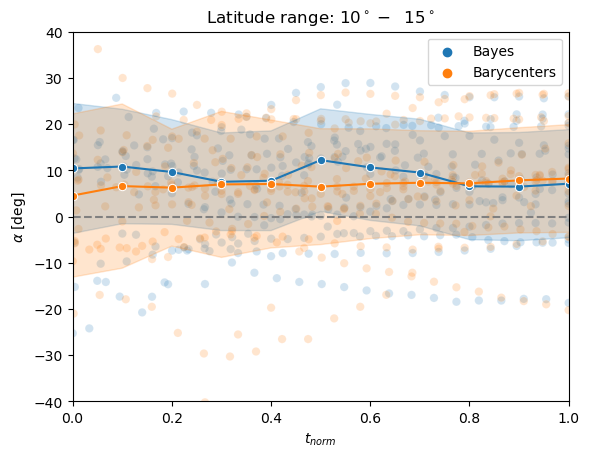

range: (15, 20) / ARs: 26


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


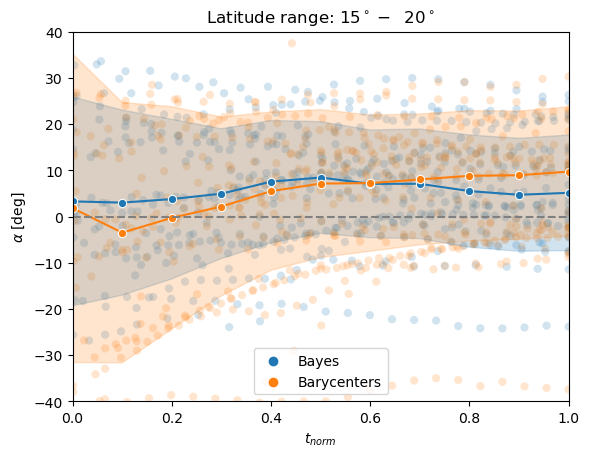

range: (20, 25) / ARs: 15


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


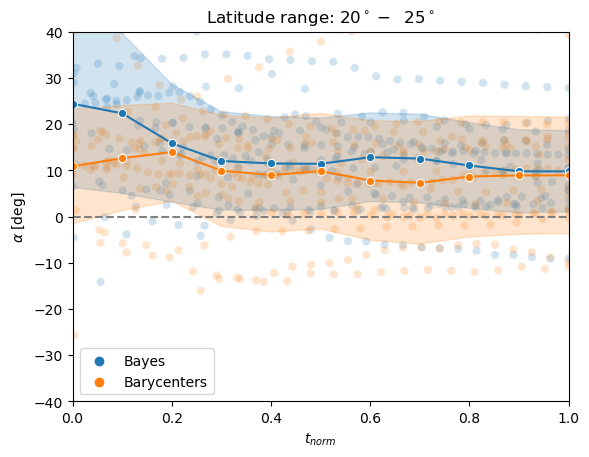

range: (25, 39) / ARs: 20


/tmp/ipykernel_24233/444289337.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()


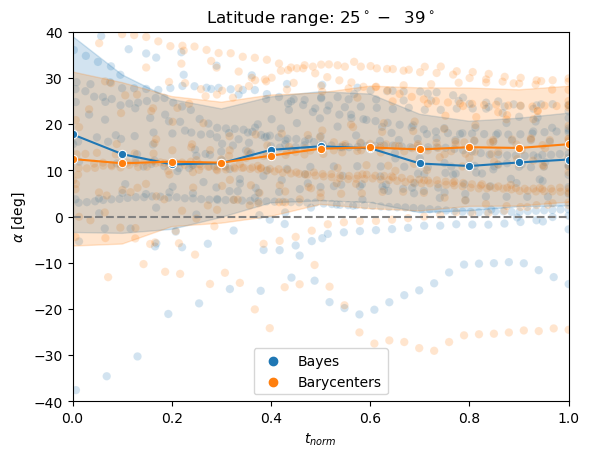

In [110]:
for r in [(0,39),(0,10),(10,15),(15,20),(20,25),(25,39)]:
    DFx2=DFx1[(np.abs(DFx1.lat) >= r[0]) & (np.abs(DFx1.lat) < r[1])]

    DFx2 = DFx2[~DFx2['AR'].isin(ARout)].copy()
    print(f'range: {r} / ARs: {len(set(DFx2.AR))}')
    
    g=sns.scatterplot(data=DFx2,x='t_norm',y='value',hue='variable',alpha=0.2)
    DFx2=DFx2.groupby(['AR','variable','t_mean']).median().reset_index()
    g=sns.lineplot(
        data=DFx2,
        x='t_mean',
        y='value',
        hue='variable',
        estimator='median',
        errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
        err_style='band',   # o 'bars' para barras verticales
        marker='o'          # opcional para marcar puntos medios
    )
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')

    plt.xlim(0,1)
    plt.ylim(-40,40)

    plt.ylabel(r'$\alpha$ [deg]')
    plt.xlabel(r'$t_{norm}$')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    
    plt.title(fr'Latitude range: {r[0]}$^\circ -$  {r[1]}$^\circ$')
    
    handles, labels = g.get_legend_handles_labels()
    
 #   plt.legend(title='',handles=handles,labels=labels[:2])

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'])
    plt.show()

In [122]:
for r in [(0,36),(0,10),(10,15),(15,20),(20,25),(25,36)]:
    
  #  resar=list(set(DF[DF.N0.abs()>0.6].AR.values))
    #resar=list(set(DF.AR.values))
    DFmax=DF.groupby('AR').max().reset_index()
    resar=list(set(DFmax[DFmax.flux>DFmax.flux.median()].AR.values))
    DFx2=DFx1[(np.abs(DFx1.lat) >= r[0]) & (np.abs(DFx1.lat) < r[1]) & (DFx1['AR'].isin(resar))]
    print(f'range: {r} / ARs: {len(set(DFx2.AR))}')
    
    g=sns.scatterplot(data=DFx2,x='t_norm',y='value',hue='variable',alpha=0.2)
    DFx2=DFx2.groupby(['AR','variable','t_mean']).mean().reset_index()
    g=sns.lineplot(
        data=DFx2,
        x='t_mean',
        y='value',
        hue='variable',
        estimator='median',
        errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
        err_style='band',   # o 'bars' para barras verticales
        marker='o'          # opcional para marcar puntos medios
    )
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')

    plt.xlim(0,1)
    plt.ylim(-40,40)

    plt.ylabel(r'$\alpha$ [deg]')
    plt.xlabel(r'$t_{norm}$')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    
    plt.title(fr'Latitude range: {r[0]}$^\circ -$  {r[1]}$^\circ$')
    
    handles, labels = g.get_legend_handles_labels()
    
 #   plt.legend(title='',handles=handles,labels=labels[:2])

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'])
    plt.show()

In [112]:
DFx1

t_norm   lat     AR        fn   mag          flux variable      value  \
0     0.001103 -22.0   8193  0.050234   0.0  5.281523e+20    alpha  55.413941   
1     0.067696 -22.0   8193  0.066990   4.0  7.043322e+20    alpha  52.658806   
2     0.134289 -22.0   8193  0.107903   8.0  1.134488e+21    alpha  26.857078   
3     0.200882 -22.0   8193  0.143195  12.0  1.505539e+21    alpha  20.252607   
4     0.267475 -22.0   8193  0.195707  16.0  2.057652e+21    alpha  19.019187   
...        ...   ...    ...       ...   ...           ...      ...        ...   
5685  0.790109  -7.0  10747  0.609831  45.0  4.781975e+21   alphab  -2.883163   
5686  0.842582  -7.0  10747  0.715223  48.0  5.608403e+21   alphab  -2.948410   
5687  0.895055  -7.0  10747  0.802347  51.0  6.291583e+21   alphab  -3.470280   
5688  0.947527  -7.0  10747  0.911246  54.0  7.145513e+21   alphab  -2.716777   
5689  1.000000  -7.0  10747  0.981142  57.0  7.693606e+21   alphab  -1.507657   

      t_mean   sin_lat  tilt_sinlat   tilt_norm   B_bin  
0        0.0  0.374607   147.925696  147.925696    high  
1        0.1  0.374607   140.570953  140.570953    high  
2        0.1  0.374607    71.694088   71.694088    high  
3        0.2  0.374607    54.063670   54.063670    high  
4        0.3  0.374607    50.771095   50.771095    high  
...      ...       ...          ...         ...     ...  
5685     0.8  0.121869   -23.657822  -23.657822  medium  
5686     0.8  0.121869   -24.193202  -24.193202  medium  
5687     0.9  0.121869   -28.475415  -28.475415  medium  
5688     0.9  0.121869   -22.292537  -22.292537  medium  
5689     1.0  0.121869   -12.371095  -12.371095  medium  

[5690 rows x 13 columns]

# Joy Plots

/tmp/ipykernel_24233/1440638234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int['lat'] = df_int['lat'].apply(lambda x: np.abs(x))
/tmp/ipykernel_24233/1440638234.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_int.groupby(['AR', 'variable']).mean().reset_index()
/tmp/ipykernel_24233/1440638234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

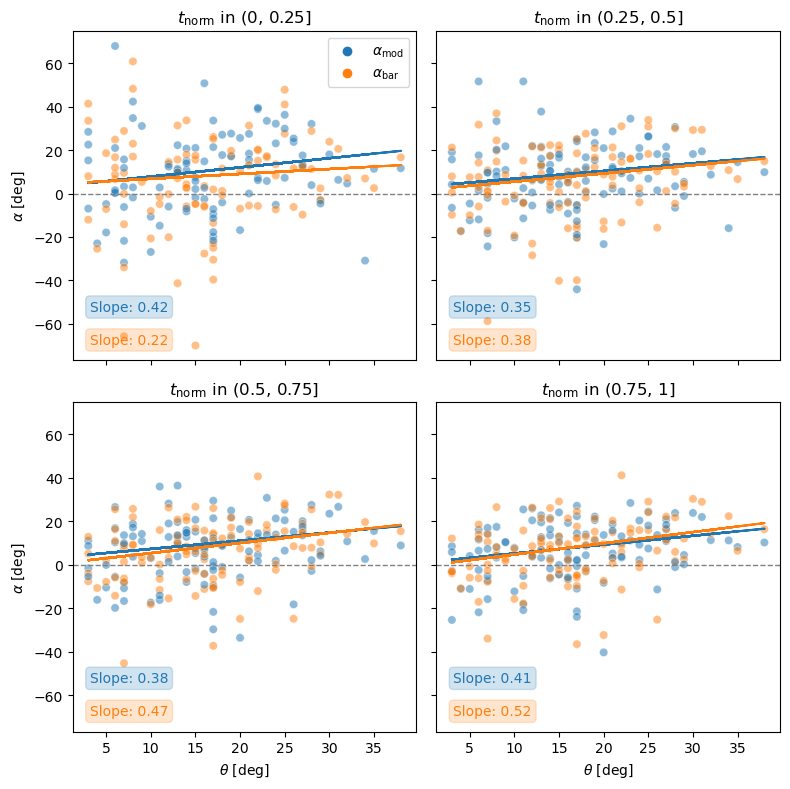

In [142]:
import scipy.stats

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.ravel()
intervals = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]

for i, (low, high) in enumerate(intervals):
    df_int = DFx1[(DFx1['t_norm'] > low) & (DFx1['t_norm'] <= high)]
    df_int['lat'] = df_int['lat'].apply(lambda x: np.abs(x))
    df_plot = df_int.groupby(['AR', 'variable']).mean().reset_index()
    sns.scatterplot(data=df_plot, x='lat', y='value', hue='variable', alpha=0.5, ax=axs[i])

    handles,labels=axs[0].get_legend_handles_labels()

    # Theil-Sen fit for each variable
    for var, color in zip(['alpha', 'alphab'], ['tab:blue', 'tab:orange']):
        dfv = df_plot[df_plot['variable'] == var]
        if len(dfv) > 1:
            res = scipy.stats.theilslopes(dfv['value'], dfv['lat'])
            axs[i].plot(dfv['lat'], res[1] + res[0]*dfv['lat'], color=color, label=f'Theil-Sen')
            axs[i].text(0.05, 0.15 if var == 'alpha' else 0.05, f"Slope: {res[0]:.2f}", color=color,
                        transform=axs[i].transAxes, fontsize=10, bbox=dict(boxstyle="round", alpha=0.2, color=color))

    
    if i in range(1,4):
        axs[i].legend().remove()
    axs[i].set_title(f"$t_\mathrm{{norm}}$ in ({low}, {high}]")
    axs[i].axhline(0, color='gray', linestyle='dashed', linewidth=1)
    axs[i].set_xlabel(r'$\theta$ [deg]')
    axs[i].set_ylabel(r'$\alpha$ [deg]')

axs[0].legend(handles=handles,labels=[r'$\alpha_\mathrm{mod}$',r'$\alpha_\mathrm{bar}$'],title='',loc='upper right')

plt.tight_layout()
#plt.legend()
plt.show()



#g.ax_marg_y.legend()
#g.ax_marg_y.legend(title=r'$t_{norm}$',labels=['0.9','0.5','0.1'],loc='upper right')
#handles,labels=hist.get_legend_handles_labels()

In [151]:
import numpy as np
import scipy.stats
from sklearn.metrics import r2_score, mean_squared_error

def theil_sen_ci(x, y, n_boot=1000, ci=95):
    slopes = []
    intercepts = []
    rng = np.random.default_rng()
    for _ in range(n_boot):
        idx = rng.choice(len(x), len(x), replace=True)
        try:
            res = scipy.stats.theilslopes(y[idx], x[idx])
            slopes.append(res[0])
            intercepts.append(res[1])
        except Exception:
            continue
    lower = (100 - ci) / 2
    upper = 100 - lower
    slope_ci = np.percentile(slopes, [lower, upper])
    intercept_ci = np.percentile(intercepts, [lower, upper])
    return np.mean(slopes), np.mean(intercepts), slope_ci, intercept_ci

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.ravel()
intervals = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1)]

for i, (low, high) in enumerate(intervals):
    df_int = DFx1[(DFx1['t_norm'] > low) & (DFx1['t_norm'] <= high)]
    df_int['lat'] = df_int['lat'].apply(lambda x: np.abs(x))
    df_plot = df_int.groupby(['AR', 'variable']).median().reset_index()
    sns.scatterplot(data=df_plot, x='lat', y='value', hue='variable', alpha=0.5, ax=axs[i])

    for var, color in zip(['alpha', 'alphab'], ['tab:blue', 'tab:orange']):
        dfv = df_plot[df_plot['variable'] == var]
        if len(dfv) > 1:
            slope, intercept, slope_ci, intercept_ci = theil_sen_ci(dfv['lat'].values, dfv['value'].values)
            x_fit = np.linspace(dfv['lat'].min(), dfv['lat'].max(), 100)
            y_fit = intercept + slope * x_fit
            y_fit_lower = intercept_ci[0] + slope_ci[0] * x_fit
            y_fit_upper = intercept_ci[1] + slope_ci[1] * x_fit
            axs[i].plot(x_fit, y_fit, color=color, label=f'Theil-Sen')
            axs[i].fill_between(x_fit, y_fit_lower, y_fit_upper, color=color, alpha=0.2)
            axs[i].text(
                0.05, 0.15 if var == 'alpha' else 0.05,
                f"a: {slope:.2f} ± {((slope_ci[1]-slope_ci[0])/2):.2f}",
                color=color,
                transform=axs[i].transAxes,
                fontsize=10,
                bbox=dict(boxstyle="round", alpha=0.2, color=color)
            )

            axs[i].text(
                0.55, 0.15 if var == 'alpha' else 0.05,
                f"b: {intercept:.1f} ± {((intercept_ci[1]-intercept_ci[0])/2):.1f}",
                color=color,
                transform=axs[i].transAxes,
                fontsize=10,
                bbox=dict(boxstyle="round", alpha=0.2, color=color)
            )

            axs[i].text(
                0.05, 0.25 ,
                r"$\alpha = \mathrm{a}~\theta +\mathrm{b}$",
                color='black',
                transform=axs[i].transAxes,
                fontsize=10,
                bbox=dict(boxstyle="round", alpha=0.2, color='gray')
            )

            y_true = dfv['value'].values
            y_pred = intercept + slope * dfv['lat'].values
            r2 = r2_score(y_true, y_pred)
            rmse = mean_squared_error(y_true, y_pred, squared=False)

            axs[i].text(
                0.05, 0.25 if var == 'alpha' else 0.15,
                f"R²: {r2:.2f}\nRMSE: {rmse:.2f}",
                color=color,
                transform=axs[i].transAxes,
                fontsize=10,
                bbox=dict(boxstyle="round", alpha=0.2, color=color)
            )

    if i != 0:
        axs[i].legend().remove()
    axs[i].set_title(f"$t_{{norm}}$ in ({low}, {high}]")
    axs[i].axhline(0, color='gray', linestyle='dashed', linewidth=1)
    axs[i].set_xlabel(r'$\theta$ [deg]')
    axs[i].set_ylabel(r'$\alpha$ [deg]')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles=handles, labels=[r'$\alpha_\mathrm{mod}$', r'$\alpha_\mathrm{bar}$'], title='', loc='upper right')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [152]:
!pip install sklearn

ERROR: Could not find a version that satisfies the requirement sklearn (from versions: none)
ERROR: No matching distribution found for sklearn


In [140]:
handles

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0, 1) / ARs: 45


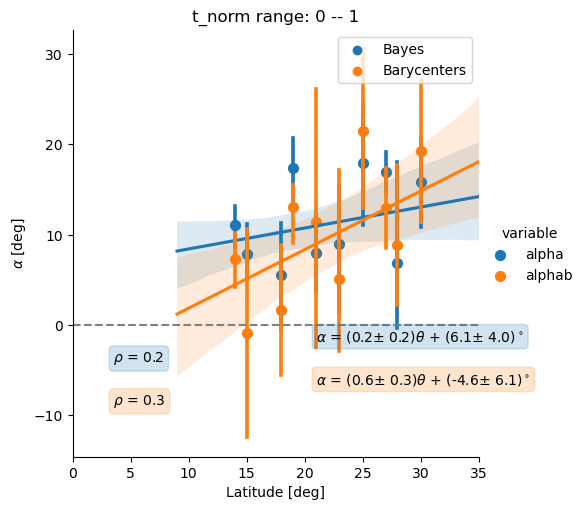

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0, 0.25) / ARs: 39


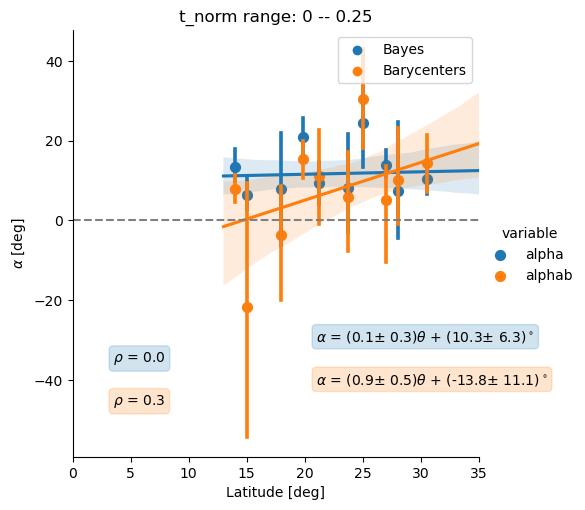

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0.25, 0.5) / ARs: 45


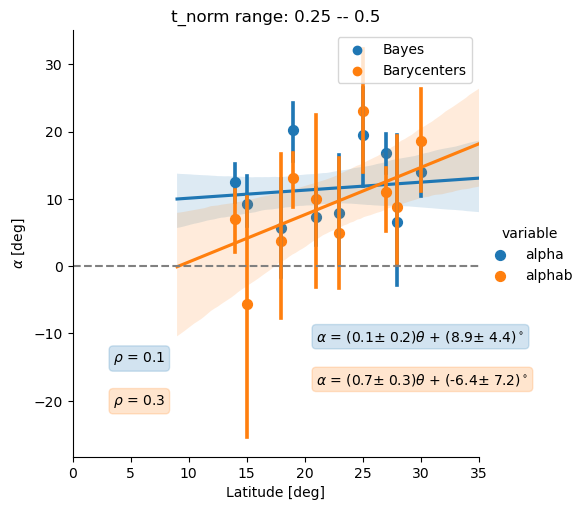

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0.5, 0.75) / ARs: 45


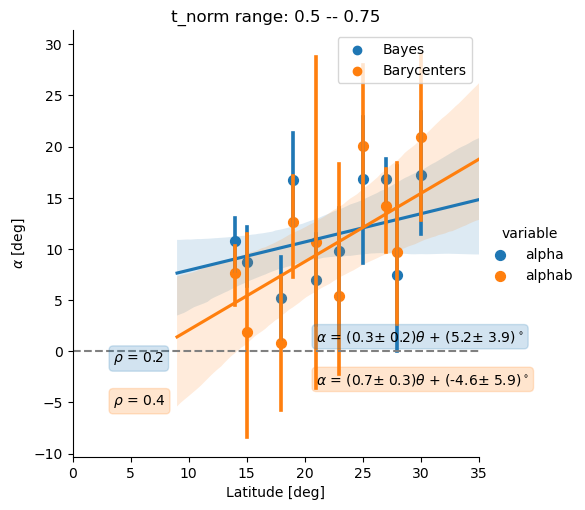

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0.75, 1) / ARs: 45


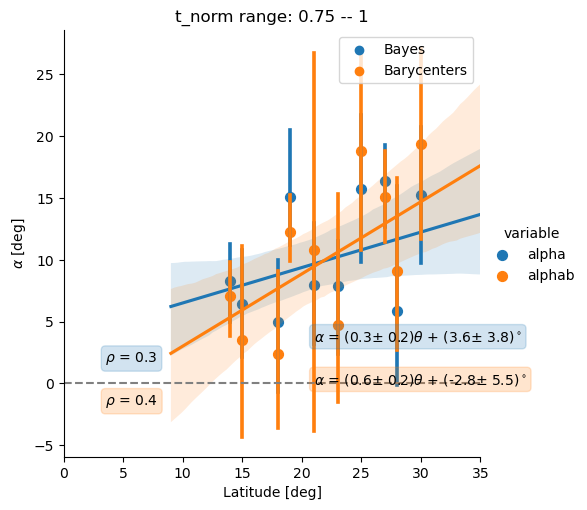

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (1, 2) / ARs: 45


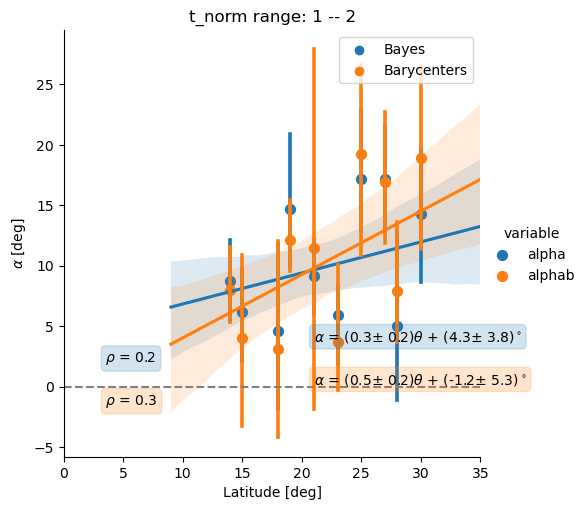

/tmp/ipykernel_24233/1747712881.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DFx2=DFx2.groupby(['AR','variable']).median().reset_index()


range: (0.99, 1.1) / ARs: 45


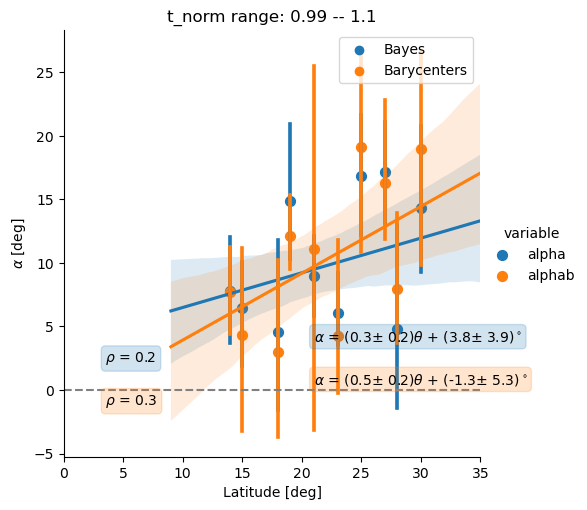

In [93]:
from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))



for r in [(0,1),(0,0.25),(0.25,0.5),(0.5,0.75),(0.75,1),(1,2),(0.99,1.1)]:
  #  resar=list(set(DF[DF.N0<0].AR.values))
 #   resar=list(set(DF.AR.values))    
#   DFmax=DF.groupby('AR').max().reset_index()
    DFx2=DFx1[(np.abs(DFx1.t_norm) >= r[0]) & (np.abs(DFx1.t_norm) < r[1])]
    DFx2=DFx2.groupby(['AR','variable']).median().reset_index()
    DFx2 = DFx2[~DFx2['AR'].isin(ARout)].copy()        
    print(f'range: {r} / ARs: {len(set(DFx2.AR))}')
    
    #g=sns.scatterplot(data=DFx2.assign(lata=lambda x:np.abs(x.lat)),x='lata',y='value',hue='variable',alpha=0.3)
    sns.lmplot(data=DFx2.assign(lata=lambda x:np.abs(x.lat)),x='lata',y='value',hue='variable',x_bins=10)
    #g=sns.lineplot(
    #    data=DFx2.assign(lata=lambda x:np.abs(x.lat),latm=lambda x:round(5*np.abs(x.lat))/5),
    #    x='lata',
    #    y='value',
    #    hue='variable',
    #    estimator='median',
    #    errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
    #    err_style='band',   # o 'bars' para barras verticales
    #    marker='o'          # opcional para marcar puntos medios
    #)
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')
    
    x=np.abs(DFx2[DFx2.variable=='alpha'].lat.values)
    y=DFx2[DFx2.variable=='alpha'].value.values
    
    ts = tinv(0.05, len(x)-2)

#    slope, intercept, rv, pv, err = stats.linregress(x, y)
    res = stats.linregress(x, y)
    
    textstr = fr"$\rho$ = {res.rvalue:.1f}"
    plt.text(0.1, 0.25, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:blue', alpha=0.2))
    
    # Agregar la pendiente y el coeficiente de correlación al gráfico
    textstr = fr"$\alpha$ = ({res.slope:.1f}$\pm$ {res.stderr:.1f})$\theta$ + ({res.intercept:.1f}$\pm$ {res.intercept_stderr:.1f})$^\circ$"
    plt.text(0.6, 0.3, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:blue', alpha=0.2))
    

    x=np.abs(DFx2[DFx2.variable=='alphab'].lat.values)
    y=DFx2[DFx2.variable=='alphab'].value.values
    
    ts = tinv(0.05, len(x)-2)

#    slope, intercept, rv, pv, err = stats.linregress(x, y)
    res = stats.linregress(x, y)
    
    # Agregar la pendiente y el coeficiente de correlación al gráfico
    textstr = fr"$\alpha$ = ({res.slope:.1f}$\pm$ {res.stderr:.1f})$\theta$ + ({res.intercept:.1f}$\pm$ {res.intercept_stderr:.1f})$^\circ$"
    plt.text(0.6, 0.2, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:orange', alpha=0.2))
    
    textstr = fr"$\rho$ = {res.rvalue:.1f}"
    plt.text(0.1, 0.15, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:orange', alpha=0.2))
    
    plt.xlim(0,35)
    plt.ylabel(r'$\alpha$ [deg]')
    plt.xlabel(r'Latitude [deg]')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    
    plt.title(fr't_norm range: {r[0]} -- {r[1]}')
    
    handles, labels = g.get_legend_handles_labels()
    

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'],loc='upper right')
    plt.show()

In [335]:
from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))



for r in [(0,1),(0,0.25),(0.25,0.5),(0.5,0.75),(0.75,1),(1,2),(0.99,1.1)]:
    DFx2=DFx1[(np.abs(DFx1.t_norm) >= r[0]) & (np.abs(DFx1.t_norm) < r[1])]
    DFx2=DFx2.groupby(['AR','variable']).median().reset_index()
    print(f'range: {r} / ARs: {len(set(DFx2.AR))}')
    
    #g=sns.scatterplot(data=DFx2.assign(lata=lambda x:np.abs(x.lat)),x='lata',y='value',hue='variable',alpha=0.3)
    sns.lmplot(data=DFx2.assign(lata=lambda x:np.sin(np.abs(np.pi*x.lat/180))),x='lata',y='value',hue='variable',x_bins=10)
    #g=sns.lineplot(
    #    data=DFx2.assign(lata=lambda x:np.abs(x.lat),latm=lambda x:round(5*np.abs(x.lat))/5),
    #    x='lata',
    #    y='value',
    #    hue='variable',
    #    estimator='median',
    #    errorbar='sd',      # 'sd' para desviación estándar, o 'ci' para intervalo de confianza
    #    err_style='band',   # o 'bars' para barras verticales
    #    marker='o'          # opcional para marcar puntos medios
    #)
 #   sns.lineplot(data=DFx2.groupby(['t_norm','variable']).median().reset_index(),x='t_norm',y='value',hue='variable')
    
    x=np.sin(np.pi*np.abs(DFx2[DFx2.variable=='alpha'].lat.values/180))
    y=DFx2[DFx2.variable=='alpha'].value.values
    
    ts = tinv(0.05, len(x)-2)

#    slope, intercept, rv, pv, err = stats.linregress(x, y)
    res = stats.linregress(x, y)
    
    textstr = fr"$\rho$ = {res.rvalue:.1f}"
    plt.text(0.1, 0.25, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:blue', alpha=0.2))
    
    # Agregar la pendiente y el coeficiente de correlación al gráfico
    textstr = fr"$\alpha$ = ({res.slope:.1f}$\pm$ {res.stderr:.1f})$\theta$ + ({res.intercept:.1f}$\pm$ {res.intercept_stderr:.1f})$^\circ$"
    plt.text(0.6, 0.3, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:blue', alpha=0.2))
    

    x=np.sin(np.pi*np.abs(DFx2[DFx2.variable=='alphab'].lat.values/180))
    y=DFx2[DFx2.variable=='alphab'].value.values
    
    ts = tinv(0.05, len(x)-2)

#    slope, intercept, rv, pv, err = stats.linregress(x, y)
    res = stats.linregress(x, y)
    
    # Agregar la pendiente y el coeficiente de correlación al gráfico
    textstr = fr"$\alpha$ = ({res.slope:.1f}$\pm$ {res.stderr:.1f})$\theta$ + ({res.intercept:.1f}$\pm$ {res.intercept_stderr:.1f})$^\circ$"
    plt.text(0.6, 0.2, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:orange', alpha=0.2))
    
    textstr = fr"$\rho$ = {res.rvalue:.1f}"
    plt.text(0.1, 0.15, textstr, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round",color='tab:orange', alpha=0.2))
    
    #plt.xlim(0,35)
    plt.ylabel(r'$\alpha$ [deg]')
    plt.xlabel(r'Latitude [deg]')
    
    plt.axhline(0,linestyle='dashed',color='gray')
    
    plt.title(fr't_norm range: {r[0]} -- {r[1]}')
    
    handles, labels = g.get_legend_handles_labels()
    

    plt.legend(title='',handles=handles,labels=['Bayes','Barycenters'],loc='upper right')
    plt.show()

In [40]:
DF=DF.assign(difalpha=lambda x: x.alpha-x.alphab)

In [95]:
DFtest=DF[DF.AR.isin(ars2)]

In [96]:
list(set(DFtest[DFtest.alpha < -50].AR))

In [99]:
name=8016
#print(DFx1[DFx1.AR ==name])
for name in list(set(DFtest[DFtest.alpha > 60].AR)):
    sns.lineplot(DFx1[DFx1.AR ==name],x='t_norm',y='value',hue='variable',marker='o' )
    sns.lineplot(DF[DF.AR ==name],x='fint',y='alpha',marker='o' ,color='black')
    plt.title(name)
    plt.show()
#sns.lineplot(DFx1[DFx1.AR ==name],x='t_norm',y='fn',marker='o' )


In [466]:
DFx1['t_norm']=DFx1.t_norm.apply(lambda x: f'{x:.1f}')

In [467]:
sns.boxplot(data=DFx1,x='t_norm',y='value',hue='variable',showfliers=False)

In [361]:
DFx1.f_grid

In [430]:
len(tilta)

In [458]:
tilt_meana = np.nanmedian(tilta, axis=0)
tilt_stda = np.nanstd(tilta, axis=0)

tilt_meanb = np.nanmedian(tiltb, axis=0)
tilt_stdb = np.nanstd(tiltb, axis=0)

In [460]:
plt.plot(np.linspace(0,1,11), tilt_meana, label='Media del tilt')
plt.fill_between(np.linspace(0,1,11), tilt_meana - tilt_stda, tilt_meana + tilt_stda, alpha=0.3, label='±1σ')

plt.plot(np.linspace(0,1,11), tilt_meanb, label='Media del tilt')
plt.fill_between(np.linspace(0,1,11), tilt_meanb - tilt_stdb, tilt_meanb + tilt_stdb, alpha=0.3, label='±1σ')

In [231]:
DF[DF.AR == 8913]

In [ ]:
# Convertir a array 2D: (n_regiones, n_fases)
tilts_array = np.array(tilts_interp_all)

# Calcular media y std (ignorando NaNs)
tilt_mean = np.nanmean(tilts_array, axis=0)
tilt_std = np.nanstd(tilts_array, axis=0)

In [223]:
DF[DF.AR == 8913]

# OLD

In [117]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12),sharex=True)



for en,ra in enumerate([(0,12),(12,20),(20,45)]):
    axs[en].set_ylim(-5,5)

    axs[en].axhline(0,color='black')

    sns.scatterplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='rot',alpha=0.5,s=30)
    sns.scatterplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='rotb',alpha=0.5,s=30)

    sns.regplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='rot',color='tab:red',x_bins=10,label='Bayesian')
    sns.regplot(data=DF[(DF.lat.abs() >=ra[0]) & (DF.lat.abs() <ra[1])],ax=axs[en],x='fint',y='rotb',color='tab:green',x_bins=10,label='Barycenters')
    axs[en].legend()
    
    axs[en].text(.7,.1,rf'${ra[0]}^\circ<|lat|\leq {ra[1]}^\circ$', transform=axs[en].transAxes, fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round',alpha=0.5))
#    plt.set_xlabel('Normalized flux')
    axs[en].set_ylabel(r'$\Delta \alpha$ [deg/hour]')
    
fig.tight_layout(pad=1.0)

axs[2].set_xlabel('Normalized flux')



In [115]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)

DF2x=DF2[(DF2.lat.abs() >=20) & (DF2.lat.abs() <45)]


for d in [1,2,3,4]:

    
    DFx=DF2x[(DF2x['frange']==d)]
    
    sns.histplot(data=DFx,x='rot',alpha=0.5,bins=10,binrange=(-2,2),label='Bayesian',ax=axs[d-1])

    sns.histplot(data=DFx,x='rotb',alpha=0.5,bins=10,binrange=(-2,2),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.rot.mean(),color='tab:blue')
    axs[d-1].axvline(DFx.rotb.mean(),color='tab:orange')
    axs[d-1].text(0.05, 0.75, f"                     \n                 ",
             transform=axs[d-1].transAxes,
             fontsize=12,
             bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2))    
    
    mayores_cero=[]
    menores_cero=[]
    for en,at in enumerate(['rot','rotb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero.append((DFx[at] > 0).sum())
        menores_cero.append((DFx[at] < 0).sum())
        
    axs[d-1].text(0.05, 0.75, f"α > 0:\nα < 0:", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.18, 0.75, f"{mayores_cero[0]} \n{menores_cero[0]}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.24, 0.75, f"{mayores_cero[1]} \n{menores_cero[1]}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)

    
    axs[d-1].text(0.75, 0.65, f"                ",
         transform=axs[d-1].transAxes,
         fontsize=12,
         bbox=dict(facecolor='gray', edgecolor='black', boxstyle='round',alpha=0.2)) 
    
    axs[d-1].text(0.75, 0.65, r"$\bar{\alpha}:$", transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.8, 0.65, f"{DFx.rot.mean():.1f}", color='tab:blue', transform=axs[d-1].transAxes, fontsize=12)
    axs[d-1].text(0.87, 0.65, f"{DFx.rotb.mean():.1f}", color='tab:orange', transform=axs[d-1].transAxes, fontsize=12)
    
       # axs[d-1].text(0.05, 0.80, f"α < 0: ,{menores_cero[1]}", transform=axs[d-1].transAxes, fontsize=12)

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
#    axs[d-1].text(
#    0.05, 0.85-en/5,
 #   rf"$\alpha > 0: \color{{blue}}{{mayores_cero[0]}},{mayores_cero[1]}$"+f"\n"+ 
 #   rf"$\alpha < 0: {menores_cero[0]},{menores_cero[1]}$",
 #   transform=axs[d-1].transAxes,
 #   fontsize=12,
    

   
    
axs[1].legend()
    
axs[0].set_ylabel('ARs')
axs[2].set_ylabel('ARs')

axs[2].set_xlabel(r'$\Delta \alpha$ [deg/hour]')
axs[3].set_xlabel(r'$\Delta \alpha$ [deg/hour]')


fig.tight_layout(pad=1.0)

fig.show()

In [61]:


fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)

for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    
    sns.histplot(data=DFx,x='rot',alpha=0.5,bins=10,binrange=(-2,2),label='Bayesian Model',ax=axs[d-1])

    sns.histplot(data=DFx,x='rotb',alpha=0.5,bins=10,binrange=(-2,2),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

    axs[d-1].axvline(DFx.rot.mean(),color='tab:blue')
    axs[d-1].axvline(DFx.rotb.mean(),color='tab:orange')
    
    for en,at in enumerate(['rot','rotb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero = (DFx[at] > 0).sum()
        menores_cero = (DFx[at] < 0).sum()

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
        axs[d-1].text(
        0.05, 0.85-en/5,
        rf"$\Delta \alpha > 0: {mayores_cero}$"+f"\n"+ 
        rf"$\Delta \alpha < 0: {menores_cero}$",
        transform=axs[d-1].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", alpha=0.2,color=plt.cm.get_cmap('tab10')(en)))
   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('ARs')
axs[2].set_ylabel('ARs')

axs[2].set_xlabel(r'$\Delta \alpha / \Delta t$ [deg/hour]')
axs[3].set_xlabel(r'$\Delta \alpha / \Delta t$ [deg/hour]')


fig.tight_layout(pad=1.0)

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)

for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    DFx=DFx.assign(ratea=lambda x: x.alpha*x.rot)
    DFx=DFx.assign(rateb=lambda x: x.alphab*x.rotb)
    
    sns.histplot(data=DFx,x='ratea',alpha=0.5,bins=10,binrange=(-8,8),label='Bayesian Model',ax=axs[d-1])

    sns.histplot(data=DFx,x='rateb',alpha=0.5,bins=10,binrange=(-8,8),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

   # axs[d-1].axvline(DFx.ratea.mean(),color='tab:blue')
   # axs[d-1].axvline(DFx.rateb.mean(),color='tab:orange')
    
    for en,at in enumerate(['ratea','rateb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero = (DFx[at] > 0).sum()
        menores_cero = (DFx[at] < 0).sum()

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
        axs[d-1].text(
        0.05, 0.85-en/5,
        rf"$\alpha\Delta \alpha > 0: {mayores_cero}$"+f"\n"+ 
        rf"$\alpha\Delta \alpha < 0: {menores_cero}$",
        transform=axs[d-1].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", alpha=0.2,color=plt.cm.get_cmap('tab10')(en)))
   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('ARs')
axs[2].set_ylabel('ARs')

axs[2].set_xlabel(r'$\alpha \Delta \alpha / \Delta t$ [deg**2/hour]')
axs[3].set_xlabel(r'$\alpha \Delta \alpha / \Delta t$ [deg**2/hour]')


fig.tight_layout(pad=1.0)

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7),sharey=True,sharex=True)

axs=np.ravel(axs)

for d in [1,2,3,4]:

    
    DFx=DF2[DF2['frange']==d]
    DFx=DFx.assign(ratea=lambda x: x.rot/x.alpha)
    DFx=DFx.assign(rateb=lambda x: x.rotb/x.alphab)
    
    sns.histplot(data=DFx,x='ratea',alpha=0.5,bins=20,binrange=(-1,1),label='Bayesian Model',ax=axs[d-1])

    sns.histplot(data=DFx,x='rateb',alpha=0.5,bins=20,binrange=(-1,1),label='Barycenters',ax=axs[d-1])
    
   # sns.histplot(data=DFx,x='ratio',alpha=0.5,bins=10,binrange=(-60,60),label='Model-Barycenters')
    


    axs[d-1].axvline(0,color='black',linestyle='dashed')

   # axs[d-1].axvline(DFx.ratea.mean(),color='tab:blue')
   # axs[d-1].axvline(DFx.rateb.mean(),color='tab:orange')
    
    for en,at in enumerate(['ratea','rateb']):
        # Calcular los valores mayores y menores que cero
        mayores_cero = (DFx[at] > 0).sum()
        menores_cero = (DFx[at] < 0).sum()

        # Agregar texto con la información
        # Agregar texto con formato LaTeX
        axs[d-1].text(
        0.05, 0.85-en/5,
        rf"$\Delta \alpha / \alpha > 0: {mayores_cero}$"+f"\n"+ 
        rf"$\Delta \alpha / \alpha < 0: {menores_cero}$",
        transform=axs[d-1].transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", alpha=0.2,color=plt.cm.get_cmap('tab10')(en)))
   
    
    axs[d-1].legend()
    
axs[0].set_ylabel('ARs')
axs[2].set_ylabel('ARs')

axs[2].set_xlabel(r'$\Delta \alpha / (\alpha \Delta t)$ [1/hour]')
axs[3].set_xlabel(r'$\Delta \alpha / (\alpha \Delta t)$ [1/hour]')


fig.tight_layout(pad=1.0)

In [69]:
sns.regplot(data=DF,y='alpha',x='fint', x_estimator=np.mean,label='Bayesian')
sns.regplot(data=DF,y='alphab',x='fint', x_estimator=np.mean,label='Barycenters')


plt.legend()
plt.ylabel(r'$\alpha$ [deg]')
plt.xlabel(r'Normalized flux')


In [48]:
sns.regplot(data=DF,y='rot',x='fint',x_bins=[0.25,0.5,0.75,1],label='Bayesian')
sns.regplot(data=DF,y='rotb',x='fint',x_bins=[0.25,0.5,0.75,1],label='Barycenters')


plt.legend()
plt.ylabel(r'$\Delta\alpha/\Delta t$ [deg/h]')
plt.xlabel(r'Normalized flux')


In [27]:
df_melt = DF2[['alpha','alphab','frange']].melt(['frange'], var_name='category', value_name='values')

In [39]:
g=sns.boxplot(data=df_melt,x='frange',y='values',hue='category')
plt.gca().xaxis.set_ticklabels([0.25,0.5,0.75,1])

plt.ylabel(r'$\alpha$ [deg]')

# Edit legend title and labels
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ["Bayesian", "Barycenters"], title=" ")

In [47]:
df_melt = DF2[['rot','rotb','frange']].melt(['frange'], var_name='category', value_name='values')
g=sns.boxplot(data=df_melt,x='frange',y='values',hue='category',showfliers=False)
plt.gca().xaxis.set_ticklabels([0.25,0.5,0.75,1])

plt.ylabel(r'$\Delta\alpha/\Delta t$ [deg/h]')

# Edit legend title and labels
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ["Bayesian", "Barycenters"], title=" ")

In [38]:
DF2[DF2.AR == 10879][['alpha','alphab','lat','frange']]

In [45]:
plt.plot(DF[DF.AR == 10879].alpha*180/np.pi)
plt.show()
plt.plot(DF2[DF2.AR == 10879].fint)
plt.show()
plt.plot(DF[DF.AR == 10879].alpha*180/np.pi)
plt.show()

In [52]:
plt.plot(DF[DF.AR == 10268].alpha*180/np.pi)



In [46]:
DF[(DF.fint > 0) & (DF.fint <= 0.25)].groupby(['AR']).mean()